<a href="https://colab.research.google.com/github/davidfague/Model_Reduction_Methods/blob/main/Extracellular_Potential_realistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single Cell Extracellular Potential

## Choose Simulation Run

In [1]:
reduce_cell=False #use neuron_reduce to reduce each dendritic tree into a semi-equivalent single cable
expand_cable=False #use cable_expander to expand apical cable into an equivalent ideal dendritic tree
choose_branches=22 #choose the number of branches if using cable_expander
synapse_distribution='original_syns' # Case to run
if synapse_distribution == 'original_syns': # original case for distal tuft excitation or somatic excitation
  original_syns=True #decides whether to use original synapse distribution (True -- stimulate distal tufts or soma to view LFP profile; False -- stimulate uniformly
else:
  original_syns=False

In [2]:
# inh_frs={
#         "proximal": {"m":16.9, "s":14.3, "rhythmicity":{"f":64, "mod":0.4}},
#         "distal": {"m":3.9, "s":4.9, "rhythmicity":{"f":"None", "mod":"None"}}
#     }

### Download Dependencies from Github

In [3]:
!pip install neuron

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 58.6 MB/s eta 0:00:00


In [4]:
!pip install neuron_reduce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!git clone https://github.com/davidfague/Model_Reduction_Methods.git

Cloning into 'Model_Reduction_Methods'...
remote: Enumerating objects: 1243, done.
remote: Counting objects: 100% (469/469), done.
remote: Compressing objects: 100% (276/276), done.
remote: Total 1243 (delta 250), reused 349 (delta 193), pack-reused 774
Receiving objects: 100% (1243/1243), 8.54 MiB | 4.08 MiB/s, done.
Resolving deltas: 100% (679/679), done.


In [6]:
%cd Model_Reduction_Methods/

#import reduction and expansion functions
from test_neuron_reduce.subtree_reductor_func import subtree_reductor
from cable_expander_func import cable_expander

#import recording functions
from stylized_module.recorder import Recorder

# #import analysis functions
# from utils import make_seg_df,generate_stylized_geometry,make_reduced_seg_df,plot_morphology,check_connectivity,generate_reduced_cell_seg_coords, create_seg_var_report

# from modeling_module.synapses import Synapse, Listed_Synapse
# from modeling_module.cell_model import cell_model
import pandas as pd

/content/Model_Reduction_Methods


In [7]:
%cd expand_example

/content/Model_Reduction_Methods/expand_example


In [8]:
# compile the mod files
!nrnivmodl mod

/content/Model_Reduction_Methods/expand_example
Mod files: "mod/mod/AMPA_NMDA.mod" "mod/mod/AMPA_NMDA_STP_LTP.mod" "mod/mod/AMPA_NMDA_STP.mod" "mod/mod/CaDynamics_E2.mod" "mod/mod/Ca_HVA.mod" "mod/mod/Ca_LVAst.mod" "mod/mod/epsp.mod" "mod/mod/GABA_AB.mod" "mod/mod/GABA_AB_STP.mod" "mod/mod/Ih.mod" "mod/mod/Im.mod" "mod/mod/int2pyr.mod" "mod/mod/K_Pst.mod" "mod/mod/K_Tst.mod" "mod/mod/Nap_Et2.mod" "mod/mod/NaTa_t.mod" "mod/mod/NaTs2_t.mod" "mod/mod/pyr2pyr.mod" "mod/mod/SK_E2.mod" "mod/mod/SKv3_1.mod" "mod/mod/vecevent.mod"

Creating 'x86_64' directory for .o files.

 -> NMODL ../mod/AMPA_NMDA_STP_LTP.mod
 -> Compiling mod_func.cpp
 -> NMODL ../mod/AMPA_NMDA_STP.mod
 -> NMODL ../mod/AMPA_NMDA.mod
Translating AMPA_NMDA_STP_LTP.mod into /content/Model_Reduction_Methods/expand_example/x86_64/AMPA_NMDA_STP_LTP.c
Translating AMPA_NMDA.mod into /content/Model_Reduction_Methods/expand_example/x86_64/AMPA_NMDA.c
Thread Safe
Translating AMPA_NMDA_STP.mod into /content/Model_Reduction_Methods/exp

In [9]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import ipywidgets as widgets
from neuron import h
from scipy import signal
from IPython.display import display, clear_output
from ipywidgets import interactive_output, HBox, VBox, Label, Layout

from __future__ import division
from neuron import gui,h
import numpy as np
import time
import matplotlib.pyplot as plt

%matplotlib inline


h.load_file('stdrun.hoc')
# h.nrn_load_dll(paths.COMPILED_LIBRARY_REDUCED_ORDER)  # choose the set of mechanisms
h.nrn_load_dll('./x86_64/.libs/libnrnmech.so')


1.0

### Modules in notebook

In [10]:
from abc import ABC, abstractmethod
from typing import List, Optional, Any, TYPE_CHECKING
import numpy as np
class PointCurrent(ABC):
    """A module for current point process"""

    def __init__(self, cell, sec_index, loc=0.5):
        """
        cell: target cell object
        sec_index: index of the target section in the section list
        loc: location on a section, between [0,1]
        """
        self.cell = cell
        self.sec_index = sec_index
        self.loc = loc
        self.pp_obj = None  # point process object
        self.rec_vec = None  # vector for recording

    @abstractmethod
    def setup(self, record: bool = None) -> None:
        pass

    def setup_recorder(self):
        size = [round(h.tstop / h.dt) + 1] if hasattr(h, 'tstop') else []
        self.rec_vec = h.Vector(*size).record(self.pp_obj._ref_i)

    def get_section(self) -> h.Section:
        return self.cell.all[self.sec_index]

    def get_segment(self):
        return self.pp_obj.get_segment()

    def get_segment_id(self) -> int:
        """Get the index of the injection target segment in the segment list"""
        iseg = int(self.get_segment().x * self.get_section().nseg)
        return self.cell.sec_id_in_seg[self.sec_index] + iseg
class CurrentInjection(PointCurrent):
    """A module for current injection
    was current: Optional[np.ndarray, List[int]] = None,
    """

    def __init__(self, cell, sec_index: int, loc: float = 0.5,
                 pulse: bool = True, current: Optional[np.ndarray] = None,
                 dt: Optional[np.ndarray] = None, record: bool = False, **pulse_param: Any) -> None:
        """
        cell: target cell object
        sec_index: index of the target section in the section list
        loc: location on a section, between [0,1]
        pulse: If True, use pulse injection with keyword arguments in 'pulse_param'
               If False, use waveform resources in vector 'current' as injection
        Dt: current vector time step size
        record: If True, enable recording current injection history
        """
        super().__init__(cell, sec_index, loc)
        self.pp_obj = h.IClamp(self.get_section()(self.loc))
        self.inj_vec = None
        if pulse:
            self.setup_pulse(**pulse_param)
        else:
            if current is None:
                current = [0]
            self.setup_current(current, dt)
        self.setup(record)

    def setup(self, record: bool = False) -> None:
        if record:
            self.setup_recorder()

    def setup_pulse(self, **pulse_param: Any) -> None:
        """Set IClamp attributes. Argument keyword: attribute name, arugment value: attribute value
        was current: Optional[np.ndarray, List[int]]
        """
        for param, value in pulse_param.items():
            setattr(self.pp_obj, param, value)

    def setup_current(self, current: Optional[np.ndarray], dt: Optional[np.ndarray]) -> None:
        """Set current injection with the waveform in vector 'current'"""
        ccl = self.pp_obj
        ccl.dur = 0
        ccl.dur = h.tstop if hasattr(h, 'tstop') else 1e30
        if dt is None:
            dt = h.dt
        self.inj_vec = h.Vector()
        self.inj_vec.from_python(current)
        self.inj_vec.append(0)
        self.inj_vec.play(ccl._ref_amp, dt)
        
class Synapse(PointCurrent):
    '''
    class for adding synapses
    '''
    def __init__(self, cell, stim: h.NetStim, sec_index: int,
                  syn_type: str = 'Exp2Syn', gmax: float = 0.01, loc: float = 0.5,
                  record: bool = False): #Optional[synapse]=None possible implementation for adding existing synapses
        super().__init__(cell, sec_index, loc)
        self.stim = stim
        self.gmax = gmax
        self.__synapse_type(syn_type)
        self.setup(record)

    # PRIVATE METHODS
    def __synapse_type(self, syn_type):
        if syn_type == 'AlphaSynapse1':
            # Reversal potential (mV); Synapse time constant (ms)
            self.syn_params = {'e': 0., 'tau': 2.0}
            # Variable name of maximum conductance (uS)
            self.gmax_var = 'gmax'
        elif syn_type == 'Exp2Syn':
            self.syn_params = {'e': 0., 'tau1': 1.0, 'tau2': 3.0}
            self.gmax_var = '_nc_weight'
        else:
            raise ValueError("Synpase type not defined.")
        self.syn_type = syn_type
        self.pp_obj = getattr(h, syn_type)(self.get_section()(self.loc))

    def __setup_synapse(self):
        self.syn = self.pp_obj
        self.nc = h.NetCon(self.stim, self.syn, 1, 0, 1)
        self.ncs=[self.nc]
        for key, value in self.syn_params.items():
            setattr(self.syn, key, value)
        self.set_gmax()

    # PUBLIC METHODS
    def setup(self, record: bool = False):
        self.__setup_synapse()
        if record:
            self.setup_recorder()
    
    def set_gmax(self, gmax: float = None):
        if gmax is not None:
            self.gmax = gmax
        if self.gmax_var == '_nc_weight':
            self.nc.weight[0] = self.gmax
        else:
            setattr(self.syn, self.gmax_var, self.gmax)
            
class Listed_Synapse():
    '''
    class for going from synapses_list and netcons_list to storing and recording synapses
    '''
    def __init__(self,synapse_obj,netcon_objs,record=True): 
        self.pp_obj = synapse_obj  # point process object
        self.syn = synapse_obj
        self.ncs = netcon_objs # NetCon objects pointing toward point process
        self.rec_vec = None  # vector for recording
        self.current_type = None # string denotes the ionic current variable that is being recording such as "i", "iampa_inmda", or "igaba" to
        self.__synapse_type(self.pp_obj.hname().split('[')[0])  # Remove index from synapse name to get syn_type
        self.setup(record)

    # PRIVATE METHODS
    def __synapse_type(self, syn_type):
        '''
        Determine conductance variable from the synapse modfile
        '''
        if syn_type == 'AlphaSynapse1':
            # Reversal potential (mV); Synapse time constant (ms)
#             self.syn_params = {'e': 0., 'tau': 2.0} # parameters should already be assigned; shouldn't need this attribute; have a dictionary for synapse parameters.
            # Variable name of maximum conductance (uS)
            self.gmax_var = 'gmax'
        elif syn_type == 'Exp2Syn':
#             self.syn_params = {'e': 0., 'tau1': 1.0, 'tau2': 3.0}
            self.gmax_var = '_nc_weight'
        elif syn_type == 'pyr2pyr':
            self.gmax_var = 'initW'
        elif syn_type == 'int2pyr':
            self.gmax_var = 'initW'
        elif 'AMPA_NMDA' in syn_type:
            self.gmax_var = 'initW'
        elif 'GABA_AB' in syn_type:
            self.gmax_var = 'initW'
        else:
            raise ValueError("Synpase type not defined.")
        self.syn_type = syn_type
#         self.pp_obj = getattr(h, syn_type)(self.get_section()(self.loc)) # not necessary to create new synapse object in this class

    def setup(self,record):
        if record:
            self.setup_recorder()

    def setup_recorder(self):
          size = [round(h.tstop/h.dt)+1] if hasattr(h,'tstop') else []
          try:
              self.rec_vec = h.Vector(*size).record(self.pp_obj._ref_igaba)
              self.current_type = "igaba"
          except: 
              try:
                self.rec_vec = MultiSynCurrent()
                vec_inmda = h.Vector(*size).record(self.pp_obj._ref_inmda)
                vec_iampa = h.Vector(*size).record(self.pp_obj._ref_iampa)
                self.rec_vec.add_vec(vec_inmda)
                self.rec_vec.add_vec(vec_iampa)
                self.current_type = "iampa_inmda"
              except:
                self.rec_vec = h.Vector(*size).record(self.pp_obj._ref_i)
                self.current_type = "i"
    # PUBLIC METHODS       
    def set_gmax(self, gmax: float = None):
        if gmax is not None:
            self.gmax = gmax
        if self.gmax_var == '_nc_weight':
            for nc in self.ncs:
                nc.weight[0] = self.gmax
        else:
            setattr(self.syn, self.gmax_var, self.gmax)

    def get_section(self) -> h.Section:
        if self.pp_obj.get_segment().sec is not None:
            return self.pp_obj.get_segment().sec
        else:
            raise ValueError("Section index not set for this Listed_Synapse object.")

    def get_segment(self):
        if self.pp_obj.get_segment() is not None:
            return self.pp_obj.get_segment()
        else:
            raise ValueError("Segment not set for this Listed_Synapse object.")

    def set_syn_params(self, **params):
        for param, value in params.items():
            setattr(self.pp_obj, param, value)
                  

class MultiSynCurrent(object):
    '''
    Class for storing inmda and iampa 
    '''
    def __init__(self):
        self.vec_list = []
    
    def add_vec(self,vec):
        self.vec_list.append(vec)
    
    def as_numpy(self):
        return np.sum(np.array([vec.as_numpy() for vec in self.vec_list]), axis=0)

In [11]:
from neuron import h
from typing import Optional, Union, List
import numpy as np
import pandas as pd
import math
from neuron import h
from typing import Optional, Union, List
import numpy as np
import pandas as pd
import math
import os
import h5py
import csv
import matplotlib.pyplot as plt

from stylized_module.recorder import Recorder
# from modeling_module.synapses import CurrentInjection, Synapse, Listed_Synapse

class cell_model():
  '''expanded cell model class for ECP calculation
  takes hoc cell model and does bookkeeping for analysis functions
  '''
  def __init__(self,model,synapses_list=None,netcons_list=None,gen_3d=True,gen_geom_csv=False,spike_threshold: Optional[float] = None):
    self.all=model.all
    self.soma=model.soma
    self.apic=model.apic
    self.dend=model.dend
    self.axon=model.axon
    #convert nrn section lists to python lists if applicable
    self.all=self.__convert_sectionlist(sectionlist=self.all)
    self.soma=self.__convert_sectionlist(sectionlist=self.soma, return_singles=True) #if sectionlist contains only one section returns just the section instead of list of sections
    self.dend=self.__convert_sectionlist(sectionlist=self.dend)
    self.apic=self.__convert_sectionlist(sectionlist=self.apic)
    self.axon=self.__convert_sectionlist(sectionlist=self.axon)
    self.spike_threshold = spike_threshold
    self.synapses_list=synapses_list #list of synapse objects from model reduction
    self.netcons_list=netcons_list # list of netcon objects from model reduction
    self.segments=[] # list for nrn segment objects
    self.injection=[] # list of injection objects
    self.synapse=[] # list of python synapse class objects
    self.sec_id_lookup = {}  # dictionary from section type id to section index
    self.sec_id_in_seg = []  # index of the first segment of each section in the segment list
    self.sec_angs = [] # list of angles that were used to branch the cell
    self.sec_rots = []
    self.__generate_sec_coords()
    self.__store_segments()
    self.__set_spike_recorder()
    self.__calc_seg_coords()
    self.__store_synapses_list() #store and record synapses from the synapses_list used to initialize the cell
    self.__get_segment_info__()
    self.grp_ids = []
    if gen_geom_csv==True:
      self.__generate_geometry_file()
    # self.calculate_netcons_per_seg()
    self.__insert_unused_channels()
    self.__setup_recorders()
  
  def __calc_seg_coords(self):
      """
      Calculate segment coordinates for ECP calculation
      Has been updated to include cases where nrn.Section objects are defined by more than 2 3D coordinates. 
      """
      nseg_total = sum(sec.nseg for sec in self.all)
      p0 = np.empty((nseg_total, 3))
      p1 = np.empty((nseg_total, 3))
      p05 = np.empty((nseg_total, 3))
      r = np.empty(nseg_total)
      seg_idx = 0
      for sec in self.all:
          nseg = sec.nseg
          pt0 = np.array([sec.x3d(0), sec.y3d(0), sec.z3d(0)])
          seg_length=sec.L/sec.nseg
          for i in range(sec.n3d()-1):
            arc_length_before = sec.arc3d(i)
            arc_length_after = sec.arc3d(i+1)
            for seg in sec:
                if (arc_length_before/sec.L) <= seg.x < (arc_length_after/sec.L):
                    seg_x_between_coordinates = (seg.x * sec.L - arc_length_before) / (arc_length_after - arc_length_before)
                    x_before, y_before, z_before = sec.x3d(i), sec.y3d(i), sec.z3d(i)
                    x_after, y_after, z_after = sec.x3d(i+1), sec.y3d(i+1), sec.z3d(i+1)
                    x_coord = x_before + (x_after - x_before) * seg_x_between_coordinates
                    y_coord = y_before + (y_after - y_before) * seg_x_between_coordinates
                    z_coord = z_before + (z_after - z_before) * seg_x_between_coordinates
                    pt1 = np.array([x_coord, y_coord, z_coord])
                    dx = (x_after - x_before) * (seg_length / 2) / (arc_length_after - arc_length_before)
                    dy = (y_after - y_before) * (seg_length / 2) / (arc_length_after - arc_length_before)
                    dz = (z_after - z_before) * (seg_length / 2) / (arc_length_after - arc_length_before)
                    pt0 = pt1 - np.array([dx, dy, dz])
                    pt2 = pt1 + np.array([dx, dy, dz])
                    p0[seg_idx] = pt0
                    p1[seg_idx] = pt2
                    p05[seg_idx] = pt1
                    r[seg_idx] = seg.diam/2
                    seg_idx += 1
      self.seg_coords = {'p0': p0, 'p1': p1, 'pc': p05, 'r': r, 'dl': p1 - p0}
      return self.seg_coords 
     

  def __store_segments(self):
    self.segments = []
    self.sec_id_in_seg = []
    nseg = 0
    for sec in self.all:
        self.sec_id_in_seg.append(nseg)
        nseg += sec.nseg
        for seg in sec:
            self.segments.append(seg)
#             self.__store_point_processes(seg) #may be outdated (was storing netcons from netcons list into self.injection 
    self._nseg = nseg

  def __store_synapses_list(self):
    '''
    store and record synapses from the list from model reduction algorithm
    '''
    temp_list=[] # generate temp list that has each netcon's synapse obj
    for netcon in self.netcons_list:
      syn=netcon.syn()
      if syn in self.synapses_list:
        syn_seg_id=self.segments.index(netcon.syn().get_segment())
        if syn in self.segments[syn_seg_id].point_processes():
          temp_list.append(syn)
        else:
          temp_list.append(None)
          print("Warning: synapse not in designated segment's point processes")

      else:
        temp_list.append(None)
        print("Warning: potentially deleted synapse:","|NetCon obj:",netcon,"|Synapse obj:",syn,"the NetCon's synapse is not in synapses_list. Check corresponding original cell's NetCon for location, etc.")
    # now use temp list to assign each synapse its netcons
    for synapse in self.synapses_list:
      synapse_netcons=[]
      if synapse in temp_list:
        num_netcons=temp_list.count(synapse)
        START=0
        for i in range(num_netcons):
          netcon_id=temp_list.index(synapse,START) #get all the netcon indices that are pointed toward this synapse # use np.where() instead of index() to return multiple indices.
          START=netcon_id+1
          synapse_netcons.append(self.netcons_list[netcon_id])
        self.synapse.append(Listed_Synapse(synapse,synapse_netcons)) #record synapse and add to the list
      else:
        print('Warning: no NetCon objects (presynaptic spike trains) pointed at', synapse)

  def __store_point_processes(self,seg):
    '''
    May be outdated. should not be used. May need to change self.injection
    '''
    for pp in seg.point_processes():
        self.injection.append(pp)

  def __set_spike_recorder(self, threshold: Optional = None):
      if threshold is not None:
          self.spike_threshold = threshold
      if self.spike_threshold is None:
          self.spikes = None
      else:
          vec = h.Vector()
          nc = h.NetCon(self.soma(0.5)._ref_v, None, sec=self.soma)
          nc.threshold = self.spike_threshold
          nc.record(vec)
          self.spikes = vec

  def get_spike_time(self, index: Union[np.ndarray, List[int], int, str] = 0) -> np.ndarray:
      """
      Return soma spike time of the cell by index (indices), ndarray (list of ndarray)
      Parameters
      index: index of the cell to retrieve the spikes from
      """
      if self.spike_threshold is None:
          raise ValueError("Spike recorder was not set up.")
      if type(index) is str and index == 'all':
          index = range(self.ncell)
      if not hasattr(index, '__len__'):
          spk = self.spikes.as_numpy().copy()
      else:
          index = np.asarray(index).ravel()
          spk = np.array([self.spikes.as_numpy().copy() for i in index], dtype=object)
      return spk

  def add_injection(self, sec_index, **kwargs):
        """Add current injection to a section by its index"""
        self.injection.append(CurrentInjection(self, sec_index, **kwargs))

  def add_synapse(self, stim: h.NetStim, sec_index: int, **kwargs):
        """Add synapse to a section by its index"""
        new_syn=Synapse(self, stim, sec_index, **kwargs)
        self.netcons_list.append(new_syn.nc)
        self.synapse.append(new_syn)

  def __generate_sec_coords(self):
      section_obj_list = self.all
      parent_sections = [] # list for already seen parent_sections of this type

      for sec in section_obj_list:
          if sec.n3d() == 0: # only for sections without already 3D coordinates
              print("Generating 3D coordinates for: ", sec)

              if sec is self.soma:
                  self.sec_angs.append(0)
                  self.sec_rots.append(0)
                  if sec.nseg != 1:
                      print('Changing soma nseg from', sec.nseg, 'to 1')
                      sec.nseg = 1
                  
                  pt0 = [0., -1 * sec.L / 2., 0.]
                  pt1 = [0., sec.L / 2., 0.]
                  sec.pt3dclear()
                  sec.pt3dadd(*pt0, sec.diam)
                  sec.pt3dadd(*pt1, sec.diam)
              else:
                  if sec.parentseg() is not None:
                      pseg = sec.parentseg()
                      psec = pseg.sec
                      nbranch = len(psec.children())
                  else:
                      print(sec,"is attached to None")
                      psec = None
                      nbranch = 1

                  # Get random theta and phi values for apical tuft and basal dendrites
                  if sec in self.apic:
                      if sec!=self.apic[0]: #trunk
                        theta = np.random.uniform(0, np.pi / 2)
                        phi = np.random.uniform(0, 2 * np.pi)
                      else:
                        theta = 0
                        phi = np.pi/2
                  elif sec in self.dend:
                      theta = np.random.uniform(np.pi / 2, np.pi)
                      phi = np.random.uniform(0, 2 * np.pi)
                  else:
                      theta, phi = 0, 0

                  parent_sections.append(psec)
                  length = sec.L

                  # Calculate new coordinates using spherical coordinates
                  x = length * np.sin(theta) * np.cos(phi)
                  y = length * np.cos(theta)
                  z = length * np.sin(theta) * np.sin(phi)

                  # Find starting position using parent segment coordinates
                  for i in range(psec.n3d()-1):
                      arc_length_before = psec.arc3d(i)
                      arc_length_after = psec.arc3d(i+1)
                      if (arc_length_before/psec.L) <= pseg.x <= (arc_length_after/psec.L):
                          # pseg.x is between 3d coordinates i and i+1
                          psec_x_between_coordinates = (pseg.x * psec.L - arc_length_before) / (arc_length_after - arc_length_before)
                          # calculate 3d coordinates at psec_x_between_coordinates
                          x_before, y_before, z_before = psec.x3d(i), psec.y3d(i), psec.z3d(i)
                          x_after, y_after, z_after = psec.x3d(i+1), psec.y3d(i+1), psec.z3d(i+1)
                          x_coord = x_before + (x_after - x_before) * psec_x_between_coordinates
                          y_coord = y_before + (y_after - y_before) * psec_x_between_coordinates
                          z_coord = z_before + (z_after - z_before) * psec_x_between_coordinates
                          pt0 = [x_coord, y_coord, z_coord]
                          break

                  pt1 = [0., 0., 0.]
                  pt1[0] = pt0[0] + x
                  pt1[1] = pt0[1] + y
                  pt1[2] = pt0[2] + z

                  sec.pt3dclear()
                  sec.pt3dadd(*pt0, sec.diam)
                  sec.pt3dadd(*pt1, sec.diam)

              if int(sec.L) != int(length):
                  print('WARNING: generation of 3D coordinates resulted in change of section length for', sec, 'from', length, 'to', sec.L)

  def __generate_geometry_file(self):
    '''
    generates geometry file specifying name, pid, ang, radius, length, type
    work in progress
    '''
    df = pd.DataFrame()
    ids=[]
    names=[]
    types=[]
    pids=[]
    axials=[]
    nbranchs=[]
    Ls=[]
    Rs=[]
    angs=self.sec_angs
    rots=self.sec_rots
    for sec in self.all:
      # print(dir(sec))
      name=sec.name()
      # print(name)
      names.append(name)
      ids.append(names.index(name))
      _,sec_type_withinteger=name.split('.')
      sec_type,_=sec_type_withinteger.split('[')
      types.append(sec_type)
      pseg = sec.parentseg()
      if pseg == None:
        pids.append(None)
      else:
        psec=pseg.sec
        px3d=psec.x3d
        pids.append(int(names.index(psec.name())))
      # axials.append('TRUE')
      # nbranchs.append(1)
      Ls.append(sec.L)
      # print(dir(sec))
      Rs.append(sec.diam/2)
    df['id']=ids
    df['name']=names
    df['pid']=pids
    df['type']=types
    df['L']=Ls
    df['R']=Rs
    try:df['ang']=angs
    except:pass
    df['rot']=rots
    # df['axials']=axials # may need to fix
    # df['nbranch']=nbranchs # may need to fix
    self.geometry=df

  def __convert_sectionlist(self,sectionlist,return_singles=False):
    '''
    convert nrn sectionlist objects to python list
    return_singles set to true will return section instead of [section] for lists with only one section
    '''
    new_sectionlist=[]
    if str(type(sectionlist)) == "<class 'hoc.HocObject'>":
      for sec in sectionlist:
        new_sectionlist.append(sec)
    else:
      new_sectionlist=sectionlist
    if return_singles==True:
      if str(type(new_sectionlist))!="<class 'nrn.Section'>":
        if len(new_sectionlist)==1:
          new_sectionlist=new_sectionlist[0]
    return new_sectionlist

  def __insert_unused_channels(self):
      channels = [('NaTa_t', 'gNaTa_t_NaTa_t', 'gNaTa_tbar'),
                  ('Ca_LVAst', 'ica_Ca_LVAst', 'gCa_LVAstbar'),
                  ('Ca_HVA', 'ica_Ca_HVA', 'gCa_HVAbar'),
                  ('Ih', 'ihcn_Ih', 'gIhbar')]
      for channel, attr, conductance in channels:
          for sec in self.all:
              if not hasattr(sec(0.5), attr):
                  sec.insert(channel)
                  for seg in sec:
                      setattr(getattr(seg, channel), conductance, 0)
                  # print(channel, sec) # empty sections

  def __setup_recorders(self):
      self.gNaTa_T = Recorder(obj_list=self.segments, var_name='gNaTa_t_NaTa_t')
      self.ina = Recorder(obj_list=self.segments, var_name='ina_NaTa_t')
      self.ical = Recorder(obj_list=self.segments, var_name='ica_Ca_LVAst')
      self.icah = Recorder(obj_list=self.segments, var_name='ica_Ca_HVA')
      self.ih = Recorder(obj_list=self.segments, var_name='ihcn_Ih')
      self.Vm = Recorder(obj_list=self.segments)

  def __create_output_folder(self):
      nbranches = len(self.apic)-1
      nc_count = len(self.netcons_list)
      syn_count = len(self.synapses_list)
      seg_count = len(self.segments)
      

      self.output_folder_name = (
          str(h.tstop)+
          "outputcontrol_" +
          str(nbranches) + "nbranch_" +
          str(nc_count) + "NCs_" +
          str(syn_count) + "nsyn_" +
          str(seg_count) + "nseg"
      )

      if not os.path.exists(self.output_folder_name):
          print('Outputting data to ', self.output_folder_name)
          os.makedirs(self.output_folder_name)

      return self.output_folder_name

  def get_recorder_data(self):
      '''
      Method for calculating net synaptic currents and getting data after simulation
      '''
      numTstep = int(h.tstop/h.dt)
      i_NMDA_bySeg = [[0] * (numTstep+1)] * len(self.segments)
      i_AMPA_bySeg = [[0] * (numTstep+1)] * len(self.segments)
      # i_bySeg = [[0] * (numTstep+1)] * len(self.segments)

      for synapse in self.synapses_list:
          try:
              i_NMDA = np.array(synapse.rec_vec.vec_list[1])
              i_AMPA = np.array(synapse.rec_vec.vec_list[0])
              seg = synapse.get_segment_id()

              try:
                  i_NMDA_bySeg[seg] = i_NMDA_bySeg[seg] + i_NMDA
                  i_AMPA_bySeg[seg] = i_AMPA_bySeg[seg] + i_AMPA
              except:
                  pass
          except:
              continue

      i_NMDA_df = pd.DataFrame(i_NMDA_bySeg) * 1000
      i_AMPA_df = pd.DataFrame(i_AMPA_bySeg) * 1000
      

      self.data_dict = {}
      self.data_dict['spikes']=self.get_spike_time()
      self.data_dict['ih_data'] = self.ih.as_numpy()
      self.data_dict['gNaTa_T_data'] = self.gNaTa_T.as_numpy()
      self.data_dict['ina_data'] = self.ina.as_numpy()
      self.data_dict['icah_data'] = self.icah.as_numpy()
      self.data_dict['ical_data'] = self.ical.as_numpy()
      self.data_dict['Vm'] = self.Vm.as_numpy()
      self.data_dict['i_NMDA'] = i_NMDA_df
      self.data_dict['i_AMPA'] = i_AMPA_df
      # self.data_dict['i'] = i_bySeg
      self.__create_output_files(self.__create_output_folder())

      return self.data_dict

  def __create_output_files(self,output_folder_name):
      for name, data in self.data_dict.items():
        try:
          self.__report_data(f"{output_folder_name}/{name}_report.h5", data.T)
        except:
          self.__report_data(f"{output_folder_name}/{name}_report.h5", data)

  def __report_data(self,reportname, dataname):
      try:
          os.remove(reportname)
      except FileNotFoundError:
          pass

      with h5py.File(reportname, 'w') as f:
          f.create_dataset("report/biophysical/data", data=dataname)


  # def plot_seg_heatmap(self, seg_df, color_column):
  #     '''
  #     Plots a heatmap of a segment dataframe, using a specified column for color
  #     color_column  :   attribute that is per segment
  #     Can update segments dataframe so that is instead a segment class with the option of saving the dataframe when initializeing the cell?
  #     '''
  #     if isinstance(getattr(self, color_column), list):
  #         color_data = np.concatenate(getattr(self, color_column))
  #     else:
  #         color_data = getattr(self, color_column)

  #     label = color_column.capitalize()
  #     savename = color_column.lower()

  #     plt.figure(figsize=(4,10))
  #     ax = plt.scatter(seg_df["X Coord"], seg_df["Y Coord"],c = color_data, cmap='jet',)
  #     plt.vlines(110,400,500)
  #     plt.text(0,450,'100 um')
  #     plt.hlines(400,110,210)
  #     plt.text(110,350,'100 um')
  #     plt.xticks([])
  #     plt.yticks([])
  #     cbar = plt.colorbar()
  #     cbar.ax.set_ylabel(label, rotation=270)

  #     plt.box(False)
  #     plt.savefig("/"+self.output_folder_name+savename+'.svg')

  def plot_temporal_spatial_heatmap(seg_df, color_column):
      '''
      NEED TO UPDATE
      Plots a temporal-spatial heatmap of a segment dataframe, using a specified column for color
      '''
      if isinstance(seg_df[color_column].iloc[0], list):
          color_data = np.concatenate(seg_df[color_column])
      else:
          color_data = seg_df[color_column]

      label = color_column.capitalize()
      savename = color_column.lower()

      plt.figure(figsize=(10, 4))
      ax = plt.scatter(seg_df["Time (ms)"], seg_df["Distance from Soma (um)"], c=color_data, cmap='jet', alpha=0.5)
      plt.vlines(110, 400, 500)
      plt.text(0, 450, '100 um')
      plt.hlines(400, 110, 210)
      plt.text(110, 350, '100 um')
      plt.xticks([])
      plt.yticks([])
      cbar = plt.colorbar()
      cbar.ax.set_ylabel(label, rotation=270)

      plt.box(False)
      plt.xlabel('Time (ms)')
      plt.ylabel('Distance from Soma (um)')
      plt.title(label)
      plt.show()

  def write_seg_info_to_csv(self):
      with open(self.output_folder_name+'/seg_info.csv', mode='w') as file:
          writer = csv.DictWriter(file, fieldnames=self.seg_info[0].keys())
          writer.writeheader()
          for row in self.seg_info:
              writer.writerow(row)

  def __get_segment_info__(self):      
      self.seg_info = []
      k = 0
      j = 0
      for sec in self.all:
          sec_type = sec.name().split('.')[1][:4]
          for i, seg in enumerate(sec):
              self.seg_info.append({ #update to have consistent naming scheme (will then need to debug plotting functions too, but should be easy)
                  'seg': seg,
                  'seg_id': j,
                  'Beginning X Coord': self.seg_coords['p0'][i][0],
                  'Beginning Y Coord': self.seg_coords['p0'][i][1],
                  'Beginning Z Coord': self.seg_coords['p0'][i][2],
                  'Center X Coord': self.seg_coords['pc'][i][0],
                  'Center Y Coord': self.seg_coords['pc'][i][1],
                  'Center Z Coord': self.seg_coords['pc'][i][2],
                  'End X Coord': self.seg_coords['p1'][i][0],
                  'End Y Coord': self.seg_coords['p1'][i][1],
                  'End Z Coord': self.seg_coords['p1'][i][2],
                  'seg diam': seg.diam,
                  'bmtk_id': k,
                  'x': seg.x,
                  'sec': seg.sec,
                  'Type': sec_type,
                  'Sec ID': int(sec.name().split('[')[2].split(']')[0]),
                  'sec diam': sec.diam,
                  'sec nseg': seg.sec.nseg,
                  'Ra': seg.sec.Ra,
                  'seg_L': sec.L/sec.nseg,
              })
              j += 1
          k += 1
      return self.__get_parent_segment_ids()

  def __get_parent_segment_ids(self):
      for seg in self.seg_info:
          seg['parent_seg_id'] = None
      pseg_ids = []
      for i, seg in enumerate(self.seg_info):
          idx = int(np.floor(seg['x'] * seg['sec nseg']))
          if idx != 0:
              pseg_id = i-1
          else:
              pseg = seg['seg'].sec.parentseg()
              if pseg is None:
                  pseg_id = None
              else:
                  psec = pseg.sec
                  nseg = psec.nseg
                  pidx = int(np.floor(pseg.x * nseg))
                  if pseg.x == 1.:
                      pidx -= 1
                  try:
                      pseg_id = next(idx for idx, info in enumerate(self.seg_info) if info['seg'] == psec((pidx + .5) / nseg))
                  except StopIteration:
                      pseg_id = "Segment not in segments"
              self.seg_info[i]['parent_seg_id'] = pseg_id
          # pseg_ids.append(pseg_id)
      return self.__get_segment_elec_dist()

  def __get_segment_elec_dist(self):
      for seg in self.seg_info:
          seg['seg_elec_info'] = {}
      freqs = {'delta': 1, 'theta': 4, 'alpha': 8, 'beta': 12, 'gamma': 30}

      soma_passive_imp = h.Impedance()
      soma_active_imp = h.Impedance()
      nexus_passive_imp = h.Impedance()
      nexus_active_imp = h.Impedance()
      try:
          soma_passive_imp.loc(self.hobj.soma[0](0.5))
          soma_active_imp.loc(self.hobj.soma[0](0.5))
      except:
          try:
              soma_passive_imp.loc(self.soma[0](0.5))
              soma_active_imp.loc(self.soma[0](0.5))
          except:
              try:
                  soma_passive_imp.loc(self.soma(0.5))
                  soma_active_imp.loc(self.soma(0.5))
              except:
                  raise AttributeError("Could not locate soma for impedance calculation")
      try:
          nexus_passive_imp.loc(self.hobj.apic[0](0.99))
          nexus_active_imp.loc(self.hobj.apic[0](0.99))
      except:
          try:
              nexus_passive_imp.loc(self.apic[0](0.99))
              nexus_active_imp.loc(self.apic[0](0.99))
          except:
              try:
                  nexus_passive_imp.loc(self.apic(0.99))
                  nexus_active_imp.loc(self.apic(0.99))
              except:
                  raise AttributeError("Could not locate the nexus for impedance calculation")

      for freq_name, freq_hz in freqs.items():
          soma_passive_imp.compute(freq_hz + 1 / 9e9, 0) #passive from soma
          soma_active_imp.compute(freq_hz + 1 / 9e9, 1) #active from soma
          nexus_passive_imp.compute(freq_hz + 1 / 9e9, 0) #passive from nexus
          nexus_active_imp.compute(freq_hz + 1 / 9e9, 1) #active from nexus
          for i, seg in enumerate(self.segments):
              elec_dist_info = {
                  'active_soma': soma_active_imp.ratio(seg.sec(seg.x)),
                  'active_nexus': nexus_active_imp.ratio(seg.sec(seg.x)),
                  'passive_soma': soma_passive_imp.ratio(seg.sec(seg.x)),
                  'passive_nexus': nexus_passive_imp.ratio(seg.sec(seg.x))
              }
              self.seg_info[i]['seg_elec_info'][freq_name] = elec_dist_info
      return self.__calculate_netcons_per_seg()

  def __calculate_netcons_per_seg(self):
      NetCon_per_seg = [0] * len(self.seg_info)
      inh_NetCon_per_seg = [0] * len(self.seg_info)
      exc_NetCon_per_seg = [0] * len(self.seg_info)

      v_rest = -60 #used to determine exc/inh may adjust or automate
      
      # calculate number of synapses for each segment (may want to divide by segment length afterward to get synpatic density)
      for netcon in self.netcons_list:
          syn = netcon.syn()
          syn_type=syn.hname().split('[')[0]
          if syn in self.synapses_list:
              syn_seg_id = self.seg_info.index(next((s for s in self.seg_info if s['seg'] == syn.get_segment()), None))
              seg_dict = self.seg_info[syn_seg_id]
              if syn in seg_dict['seg'].point_processes():
                  NetCon_per_seg[syn_seg_id] += 1 # get synapses per segment
                  if syn_type == 'pyr2pyr':
                      exc_NetCon_per_seg[syn_seg_id] += 1
                  elif syn_type == 'int2pyr':
                      inh_NetCon_per_seg[syn_seg_id] += 1
                  elif 'AMPA_NMDA' in syn_type:
                      exc_NetCon_per_seg[syn_seg_id] += 1
                  elif 'GABA_AB' in syn_type:
                      inh_NetCon_per_seg[syn_seg_id] += 1
                  elif syn.e > v_rest:
                      exc_NetCon_per_seg[syn_seg_id] += 1
                  else:
                      inh_NetCon_per_seg[syn_seg_id] += 1
              else:
                  print("Warning: synapse not in designated segment's point processes")
          else:
              print("Warning: potentially deleted synapse:","|NetCon obj:",netcon,"|Synapse obj:",syn,"the NetCon's synapse is not in synapses_list. Check corresponding original cell's NetCon for location, etc.")
      
      for i, seg in enumerate(self.seg_info):
          seg['netcons_per_seg'] = {
              'exc': exc_NetCon_per_seg[i],
              'inh': inh_NetCon_per_seg[i],
              'total': NetCon_per_seg[i]
          }
          seg['netcon_density_per_seg'] = {
              'exc': exc_NetCon_per_seg[i]/seg['seg_L'],
              'inh': inh_NetCon_per_seg[i]/seg['seg_L'],
              'total': NetCon_per_seg[i]/seg['seg_L']
          }
      
      return 

  def plot_seg_heatmap(self, color_column, subtype=None):
      '''
      Plots a heatmap of a segment dataframe, using a specified column for color
      color_column  :   attribute that is per segment
      subtype : sub key of color column
      Can update segments dataframe so that is instead a segment class with the option of saving the dataframe when initializeing the cell?
      '''
      #may be able to replace seg_df with seg_info or self or something
      if isinstance(getattr(self.seg_info, color_column), list):
          color_data = np.concatenate(getattr(self.seg_info, color_column))
      else:
          color_data = getattr(self.seg_info, color_column)
          
      if isinstance(color_data, dict):
          if subtype is not None:
              color_data = [v.get(subtype) for v in color_data.values()]
          else:
              raise ValueError("If color_column is a dictionary, sub_type parameter must be specified")
              

      label = color_column.capitalize()
      savename = color_column.lower()

      plt.figure(figsize=(4,10))
      ax = plt.scatter(self.seg_info["X Coord"], self.seg_info["Y Coord"],c = color_data, cmap='jet',)
      plt.vlines(110,400,500)
      plt.text(0,450,'100 um')
      plt.hlines(400,110,210)
      plt.text(110,350,'100 um')
      plt.xticks([])
      plt.yticks([])
      cbar = plt.colorbar()
      cbar.ax.set_ylabel(label, rotation=270)

      plt.box(False)
      plt.show()
      plt.savefig("/"+self.output_folder_name+savename+'.svg')

In [12]:
def plot_segment_info(cell,information):
    '''
    Work in progress
    Plots seg info as heatmap over morphology
    '''
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')

    for seg in cell.seg_info:
        # Extract segment info
        seg_id = seg['seg_id']
        x_begin = seg['Beginning X Coord']
        y_begin = seg['Beginning Y Coord']
        z_begin = seg['Beginning Z Coord']
        x_middle = seg['Center X Coord']
        y_middle = seg['Center Y Coord']
        z_middle = seg['Center Z Coord']
        x_end = seg['End X Coord']
        y_end = seg['End Y Coord']
        z_end = seg['End Z Coord']

        # Plot segment as a line from beginning to middle to end
        ax.plot3D([x_begin, x_middle, x_end], [y_begin, y_middle, y_end], [z_begin, z_middle, z_end], label=f'Segment {seg_id}')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('Cell Morphology with Segment '+information)
    plt.legend()
    plt.show()


### Build complex cell

In [13]:
h.load_file('L5PCbiophys3.hoc')

# # Load morphology parameters from a csv file
# geometry = pd.read_csv(paths.GEO_REDUCED_ORDER, index_col='id')
h.load_file("import3d.hoc")


# Create a cell object
# cell = ReducedOrderL5CellPassiveDendrite(geometry=geometry, full_biophys=biophys_param)
h.load_file('L5PCtemplate.hoc')
complex_cell = h.L5PCtemplate('cell1.asc')
h.celsius = 37
h.v_init = complex_cell.soma[0].e_pas


### Generate Synapses and Inputs

In [14]:
from functools import partial
import scipy.signal as ss
import scipy.stats as st

def minmax(x):
    """min max normalizes the given array"""
    return (x - np.min(x))/(np.max(x)-np.min(x))

def generate_presynaptic_spike_train(new_syn,seg_for_synapse,excitatory):
    # parameters
    # exc mean_fr distribution
    levy_dist = partial(st.levy_stable.rvs, alpha=1.37, beta=-1.00, loc=0.92, scale=0.44, size=1)
    # proximal inh mean_fr distribution
    mean_fr, std_fr = 16.9, 14.3
    a, b = (0 - mean_fr) / std_fr, (100 - mean_fr) / std_fr
    proximal_inh_dist = partial(st.truncnorm.rvs, a=a, b=b, loc=mean_fr, scale=std_fr)
    # distal inh mean_fr distribution
    mean_fr, std_fr = 3.9, 4.3
    a, b = (0 - mean_fr) / std_fr, (100 - mean_fr) / std_fr
    distal_inh_dist = partial(st.truncnorm.rvs, a=a, b=b, loc=mean_fr, scale=std_fr)
    # release probability distributions
    P_0exc_mean, P_0exc_std = 0.53, 0.22
    P_0inh_proximal_mean, P_0inh_proximal_std = 0.72, 0.01
    P_0inh_distal_mean, P_0inh_distal_std = 0.30,0.08
    P_0inh_soma_mean, P_0inh_soma_std = 0.88,0.5
    P_0exc_dist = partial(np.random.normal,loc=P_0exc_mean, scale=P_0exc_std, size=1)
    P_0inh_proximal_dist =  partial(np.random.normal,loc=P_0inh_proximal_mean, scale=P_0inh_proximal_std, size=1)
    P_0inh_distal_dist =  partial(np.random.normal,loc=P_0inh_distal_mean, scale=P_0inh_distal_std, size=1)
    P_0inh_soma_dist =  partial(np.random.normal,loc=P_0inh_soma_mean, scale=P_0inh_soma_std, size=1)
    # gmax distributions
    m=.2
    s=0.345
    gmax_mean = np.log(m) - 0.5 * np.log((s/m)**2+1)
    gmax_std = np.sqrt(np.log((s/m)**2 + 1))
    gmax_exc_dist = partial(np.random.lognormal, gmax_mean, gmax_std, size=1)
    gmax_inh=1/1000
    # rhythmic inhibition parameters -- frequency and depth of modulation
    proximal_rhythmic_f,proximal_rhythmic_mod = 64, 0.4
    distal_rhythmic_f,distal_rhythmic_mod = 16, 0.2

    #filter coefficients
    B = [0.049922035, -0.095993537, 0.050612699, -0.004408786]
    A = [1, -2.494956002,   2.017265875,  -0.522189400]
    #generate presynaptic spike train
    #sample mean FR from distribution
    if excitatory:
      mean_fr_for_this_synapse = np.exp(levy_dist(size=1)[0]) #exc mean_fr distribution
      # new_syn.P_0 = P_0exc_dist(size=1)[0] # uncomment if using pyr2pyr
      new_syn.initW = gmax_exc_dist(size=1)[0]
    else: #inhibitory
      new_syn.initW = gmax_inh
      #inh distribution changes depending on distance from soma
      if h.distance(cell.soma[0](0.5),seg_for_synapse)<50: #perisomatic
        mean_fr_for_this_synapse = proximal_inh_dist(size=1)[0]
        # new_syn.P_0 = P_0inh_proximal_dist(size=1)[0] # uncomment if using int2pyr
        proximal=True
      else:
        mean_fr_for_this_synapse = distal_inh_dist(size=1)[0]
        # new_syn.P_0 = P_0inh_distal_dist(size=1)[0] # uncomment if using int2pyr
        proximal=False

    # generate modulatory trace 
    # rhythmic modulation or 1/f modulation
    if excitatory:
      # 1/f trace to modulate mean_fr
      invfn = np.zeros((1,int(h.tstop))) #generate one trace that goes until tstop
      wn = np.random.normal(loc=1,scale=0.5,size=(int(h.tstop)+2000))
      invfn[0,:] = minmax(ss.lfilter(B, A, wn)[2000:])+0.5 # Create '1/f' Noise
      rate_prof=np.tile(invfn[0,:],(1,1))
    else: # inhibitory
      rate_prof = np.zeros((1,t.shape[0]))
      # rhythmic modulation
      if proximal:
        
        A = mean_fr_for_this_synapse/((1/proximal_rhythmic_mod)-1)
        rate_prof[0,:] = A*np.sin((2 * np.pi * proximal_rhythmic_f * t)+P) + mean_fr_for_this_synapse
      else:
        A = mean_fr_for_this_synapse/((1/distal_rhythmic_mod)-1)
        rate_prof[0,:] = A*np.sin((2 * np.pi * distal_rhythmic_f * t)+P) + mean_fr_for_this_synapse
      # shift excitatory
      
    # combine mean_fr with moduatory trace
    try: 
        r = rate_prof[0,:]
    except:
        import pdb; pdb.set_trace()
    r[r<0] = 0#Can't have negative firing rates.
    rate_temp=[];simSpks_temp=[]

    #Multiplies the normalized modulatory trace by the sampled mean firing rate.
    rate_temp = r*mean_fr_for_this_synapse
    #sample spikes
    numbPoints = st.poisson(rate_temp/1000).rvs()#Poisson number of points

    simSpks=np.where(numbPoints>0)[0]
    inputfreq=(len(simSpks)/(h.tstop/1000)) # print the number of spikes array. dividing by tstop should give the spike frequency

    return simSpks

def generate_syns(cell,exc_dens,inh_dens):
  '''
  Generate semi-realistic synapse distribution
  '''
  #calculate total length of cell
  synapses_list=[]
  netcons_list=[]
  vecstims_list=[]
  randoms_list=[]
  total_length=0
  t = np.arange(0,h.tstop-1,1) #test
  P=0

  for sec in cell.all:
    total_length+=sec.L
  exc_syn_number=int(total_length*exc_dens)
  inh_syn_number=int(total_length*inh_dens)
  total_syns=exc_syn_number+inh_syn_number
  ratio_exc=exc_syn_number/total_syns

  rnd = np.random.RandomState(10)
  all_segments = [i for j in map(list,list(complex_cell.apical)) for i in j] + [i for j in map(list,list(complex_cell.basal)) for i in j]
  len_per_segment = np.array([seg.sec.L/seg.sec.nseg for seg in all_segments])
  for i in range(total_syns):

    #place synapse randomly
    seg_for_synapse = rnd.choice(all_segments,   p=len_per_segment/sum(len_per_segment))
    # synapses_list.append(h.Exp2Syn(seg_for_synapse))
    #assign synaptic properties
    r = h.Random()
    r.MCellRan4()
    r.uniform(0,1)
    if rnd.uniform() < ratio_exc:
        excitatory=True
        # new_syn=h.pyr2pyr(seg_for_synapse) # older exc synapse model
        new_syn=h.AMPA_NMDA(seg_for_synapse) # newer exc synapse model
        # new_syn=h.AMPA_NMDA_STP(seg_for_synapse) # newer exc synapse model with STP
        # new_syn=h.AMPA_NMDA_STP_LTP(seg_for_synapse) # newer exc synapse model with STP and LTP
    else:
        excitatory=False
        # new_syn=h.int2pyr(seg_for_synapse) # older inh synapse model
        new_syn=h.GABA_AB(seg_for_synapse) # newer inh synapse model
        # new_syn=h.GABA_AB_STP(seg_for_synapse) # newer inh synapse model with STP
    
    synapses_list.append(new_syn)

    # uncomment if using pyr2pyr, int2pyr
    # new_syn.setRandObjRef(r)
    # A list of random generators is kept so that they are not automatically garbaged.
    # randoms_list.append(r) # can be updated to keep the list
        

    #generate presynaptic spike train
    stim_spikes = generate_presynaptic_spike_train(new_syn,seg_for_synapse,excitatory)

    # make spike train into h.Vector and apply to h.VecStim
    vec = h.Vector(stim_spikes)
    new_stim=h.VecStim()
    vecstims_list.append(new_stim)
    vecstims_list[i].play(vec)

    # old code for recording things
    # writer.append_repeat("node_ids", i, len(simSpks))
    # writer.append_ds(simSpks, "timestamps")
    # stim_list.append(inhvecstim)
    # InhSpikeMatrix.append(inhspikes)
    # sectioninhspikes.append(InhSpikeMatrix)
    

    # netstims_list.append(h.NetStim())
    # netstims_list[i].interval, netstims_list[i].number, netstims_list[i].start, netstims_list[i].noise = spike_interval, 9e9, 100, 1

    # randoms_list.append(h.Random())
    # randoms_list[i].Random123(i)
    # randoms_list[i].negexp(1)
    # netstims_list[i].noiseFromRandom(randoms_list[i])

    netcons_list.append(h.NetCon(vecstims_list[i], synapses_list[i]))
    netcons_list[i].delay = 0
    #  netcons_list[i].weight[0] = syn_weight


  return synapses_list, netcons_list, vecstims_list

# def generate_inh_inputs(cell):
#   for sec in cell.all:
#     synapses=[seg.point_processes() for seg in sec] # gather synapses
#     num_presyns=len(synapses)
#     if num_presyns !=0 :
#         a, b = (0 - mean_fr) / std_fr, (100 - mean_fr) / std_fr # parameters for inh FR distribtuion 
#         d = partial(st.truncnorm.rvs, a=a, b=b, loc=mean_fr, scale=std_fr) # inhibitory FR distrubtion
#         # make an array of modulated sin waves
#         # make_save_spikes should be written so that the firing rates are generated
#         #    outside instead of inside the function.
#         frs = d(size=num_presyns)
#         t = np.arange(0,h.tstop,0.001)
#         z = np.zeros((num_presyns,t.shape[0]))
#         P = 0
#         for i in np.arange(0,num_presyns):
#             offset = frs[i]
#             A = offset/((1/rhythmic_dict['mod'])-1)
#             z[i,:] = A*np.sin((2 * np.pi * rhythmic_dict['f'] * t)+P) + offset

#         writer = SonataWriter(fname, ["spikes", key], ["timestamps", "node_ids"], [np.float, np.int])
#         make_save_spikes(writer, False, np.ones((n_cells,1)), numUnits=n_cells,rateProf=z)

  

In [15]:
# class InputBuilder:
#   '''
#   '''
  

# # place synapses
#     # uniformly

#     # in clusters

# # set synaptic properties

# # generate presynaptic spike trains
#     # excitatory
#       # 1/f psd
    
#     # inhibitory
#       # sinusoidal
#       # shifted excitatory

# # assign spike trains to synapses




In [16]:
class SonataWriter:
    """Class used to dynamically writing spike rasters to an h5 file.
    Attributes
    ----------
    file : h5py.File
        file object being worked on
    group : h5py.Group
        gropu where the datasets reside
    datasets : dict
        datasets that are saved to the file
    Methods
    -------
    append_ds(vals, ds)
        appends the given values to the end of the given dataset
    append_repeat(ds, val, N)
        appends the given value N times to the end of the given dataset
    close()
        close the h5py file
    """
    def __init__(self, f_name, groups, datasets, types):
        """
        Parameters
        ----------
        f_name : str
            name of file location
        groups : list
            list of group names (str) that are layered into the h5py file
            in the order given.
        datasets : list
            list of dataset names (str)
        types : list
            list of data types that corresponds to the datasets list
        """        
        self.file = h5py.File(f_name, 'w')

        self.group = self.file
        for group in groups:
            self.group = self.group.create_group(group)

        self.datasets = {}
        for i, ds in enumerate(datasets):
            self.datasets[ds] = self.group.create_dataset(ds, data=[], dtype=types[i], chunks=True, maxshape=(None,))

    def append_ds(self, vals, ds):
        """appends the given values to the end of the given dataset
        Parameters
        ----------
        vals : list
            list of values to be appended to the dataset
        ds : str
            key of the dataset to append to
        """        
        length = len(self.datasets[ds])
        self.datasets[ds].resize((length + len(vals), ))
        self.datasets[ds][length:] = vals

    def append_repeat(self, ds, val, N):
        """appends the given value N times to the end of the given dataset
        Parameters
        ----------
        ds : str
            key of the dataset to append to
        val : [type]
            value to be appended N times
        N : int
            number of vals to append to the dataset
        """        
        self.append_ds([val for i in range(N)], ds)

    def close(self):
        """Closes the h5py File
        """        
        self.file.close()


In [17]:
def find_distal_apical_sections(cell):
  # find distal tuft sections:
  parent_sections=[]
  for sec in cell.all: # find non-terminal sections
    if sec.parentseg() is not None:
      if sec.parentseg().sec not in parent_sections:
        parent_sections.append(sec.parentseg().sec)

  # h.distance(sec=cell.soma) #starts following h.distance calculation from soma section

  tufts=[]
  for sec in cell.apic:  # check if the section is a terminal section and if it is apical tuft
    # print(h.distance(sec(0.5)))
    if (sec not in parent_sections) and (h.distance(cell.soma(0.5),sec(0.5)) > 800):
      tufts.append(sec)
      # print(sec, 'is a terminal section of the tuft'

  return tufts

In [18]:
import random
from neuron import h,nrn,gui
#place synapses
if original_syns:
    #use defined cell_model class for generating 3d coordinates, recording ECP, 'book-keeping' etc...
  random.seed(2)

  # Create synaptic input
  stim = h.NetStim()
  frequency=5 #(hz)
  spikeinterval = (1/frequency)*1000 #convert to T and milliseconds
  stim.noise=0
  stim.interval=spikeinterval
  print(str(stim.interval))
  stim.number = 3  # only one event
  stim.start = 2.0  # delay (ms)

  gmax = 1  # default synapse maximum conductance (uS)
  synapses_list=[]
  netcons_list=[]
  cell = cell_model(complex_cell,synapses_list=synapses_list,netcons_list=netcons_list,spike_threshold = 10)
  # Add synapse to soma
  cell.add_synapse(stim, sec_index=cell.all.index(cell.soma), gmax=gmax)

  # find distal tuft sections:
  parent_sections=[]
  for sec in cell.all: # find non-terminal sections
    if sec.parentseg() is not None:
      if sec.parentseg().sec not in parent_sections:
        parent_sections.append(sec.parentseg().sec)
  h.distance(sec=cell.soma) #starts following h.distance calculation from soma section
  tufts=[]
  for sec in cell.apic:  # check if the section is a terminal section and if it is apical tuft
    # print(h.distance(sec(0.5)))
    if (sec not in parent_sections) and (h.distance(sec(0.5)) > 800):
      tufts.append(sec)
      # print(sec, 'is a terminal section of the tuft')

  # add synpase to distal tuft sections
  cell._nbranch=len(tufts)
  original_nbranch=cell._nbranch
  print(cell._nbranch, "terminal tuft branches in original cell")
  for distal_tuft_sec in tufts:
    cell.add_synapse(stim, sec_index=cell.all.index(distal_tuft_sec), gmax=gmax / cell._nbranch) # need to adjust to only tufts


# newer method under deveopment    
else: #realistic syn distribution
  exc_dens=2.16 # synapses per micron
  inh_dens=0.22 # synapses per micron
  synapses_list, netcons_list, vecstims_list = generate_syns(complex_cell,exc_dens,inh_dens) # generate synapses and inputs
  cell = cell_model(complex_cell,synapses_list,netcons_list,spike_threshold=10) # use python cell_model class
  
  # find distal tuft sections:
  tufts = find_distal_apical_sections(cell)

200.0
Generating 3D coordinates for:  L5PCtemplate[0].axon[0]
Generating 3D coordinates for:  L5PCtemplate[0].axon[1]
22 terminal tuft branches in original cell


In [21]:
if original_syns:
  #get lists for redution
  #get synapse hoc obj list from synapse python class obj list
  synapses_list=[]
  for synapse in cell.synapse:
    synapses_list.append(synapse.syn) #retrieve synapse hoc obj from python class
  netcons_list=cell.netcons_list

### Reduce Cell

In [22]:
#reduce cell
if reduce_cell==True:
  #reduce complex dendritic trees to cables
  reduced_cell, synapses_list, netcons_list, txt = subtree_reductor(complex_cell, synapses_list, netcons_list, reduction_frequency=0,return_seg_to_seg=True, total_segments_manual=200)
  print("synapses_list after NR reduction:", synapses_list)
  if expand_cable==True:
    #expand cable to idealized dendritic trees
    sections_to_expand = [reduced_cell.hoc_model.apic[0]]
    furcations_x=[0.289004]
    nbranches=[choose_branches]
    reduced_dendritic_cell, synapses_list, netcons_list, txt = cable_expander(reduced_cell, sections_to_expand, furcations_x, nbranches, 
                                                                              synapses_list, netcons_list, reduction_frequency=0,return_seg_to_seg=True)
    #remove basal dend 3d coordinates because they seem off
    for sec in reduced_dendritic_cell.dend:
      sec.pt3dclear()

    cell = cell_model(reduced_dendritic_cell,synapses_list=synapses_list,netcons_list=netcons_list,spike_threshold = 10) #NR model with apical cable converted to tree
    tufts=[] # find tufts
    for i,sec in enumerate(cell.apic):
      if i!=0: # do not add synapse to trunk
        tufts.append(sec)
    cell._nbranch=len(tufts)
    print(cell._nbranch, "terminal tuft branches in reduced_dendritic_cell")
  else:
    #workaround since cell.all was not attribute (can update cell_model class to include this list formation)
    reduced_cell.all =[]
    for sec in [reduced_cell.soma]:
      reduced_cell.all.append(sec)
    for sec in [reduced_cell.apic]:
      reduced_cell.all.append(sec)
    for sec in reduced_cell.dend:
      reduced_cell.all.append(sec)
    for sec in reduced_cell.axon:
      reduced_cell.all.append(sec)
    #make apic sec a list (can update cell_model class to include this) (cell_model class expects cell.apic to be iterable)
    reduced_cell.apic=[reduced_cell.apic]
    #use cell_model python class
    cell=cell_model(reduced_cell,synapses_list=synapses_list,netcons_list=netcons_list,spike_threshold = 10) # neuron_reduce model
    tufts=cell.apic # Vm plot may return middle segment of trunk since it is the distal apical section.
    cell._nbranch=len(tufts)
    print(cell._nbranch, "terminal tuft branches in reduced_cell")
else:
  # cell = cell_model(complex_cell,synapses_list=synapses_list,netcons_list=netcons_list,spike_threshold = 10) # original cell
  # original cell should already be defined
  pass

In [23]:
import os

RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    !pip install neuron==8.0.0 &> /dev/null
    os.chdir('/content')
    if not os.path.isdir('Stylized-Single-Cell-and-Extracellular-Potential'):
        !git clone https://github.com/chenziao/Stylized-Single-Cell-and-Extracellular-Potential.git &> /dev/null 
    os.chdir('Stylized-Single-Cell-and-Extracellular-Potential')
    %ls

cell_inference/  Stylized_Single_Cell_Extracellular_Potential_Tutorial.ipynb


### Prepare Simulation

In [24]:
from cell_inference.config import params, paths
from cell_inference.cells.activecell_axon import ReducedOrderL5Cell, ReducedOrderL5CellPassiveDendrite
from cell_inference.utils.currents.ecp import EcpMod
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.utils.plotting.plot_morphology import plot_morphology
from cell_inference.utils.plotting.plot_results import plot_lfp_heatmap, plot_lfp_traces
from cell_inference.utils.plotting.plot_variable_with_morphology import plot_variable_with_morphology
from cell_inference.utils.metrics.measure_segment_distance import measure_segment_distance

In [25]:
# Record time points
t_vec = h.Vector(round(h.tstop / h.dt) + 1).record(h._ref_t)

# Record membrane voltage of all segments
V_rec = Recorder(cell.segments)

### Add electrodes (Neuropixel)
A probe with 384 electrodes [https://www.neuropixels.org/probe](https://www.neuropixels.org/probe). The coordinates of each electrode is a row in the array printed below.

In [26]:
elec_pos = params.ELECTRODE_POSITION
ecp = EcpMod(cell, elec_pos, min_distance=params.MIN_DISTANCE)  # create an ECP object for extracellular potential

# coordinates (x, y, z) of electrodes
# print(params.ELECTRODE_POSITION.shape)
# print(params.ELECTRODE_POSITION)

## Custom settings

Using the interactive tools below, you can change the position of the cell, and change the synapse strength and location on the cell.

#### Cell position parameters (x, y, z, alpha, h, phi)
Starting with soma at the origin, apical dendrite along y-axis, rotate and translate the cell to the desired position determined by 6 parameters. First, rotate alpha about the y-axis (spin), then rotate beta=arccos(h) about the x-axis (elevation), then rotate phi about the y-axis (azimuth). Finally translate the cell by (x,y,z).

Use the sliders to change the 6 position parameters. Use the sliders 'elev' and 'azim' to change view of the 3D plot.

In [27]:
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes
import numpy as np
from typing import Union, Optional, List, Tuple

from cell_inference.utils.currents.ecp import move_position
from cell_inference.cells.stylizedcell import StylizedCell


def plot_morphology(sim: Optional = None, cellid: Optional[int] = 0, cell: Optional[StylizedCell] = None,
                    seg_coords: Optional[dict] = None, sec_nseg: Optional[List] = None,
                    type_id: Optional[List] = None, electrodes: Optional[np.ndarray] = None,
                    axes: Union[List[int], Tuple[int]] = [2, 0, 1], clr: Optional[List[str]] = None,
                    elev: int = 20, azim: int = 10, move_cell: Optional[Union[List,np.ndarray]] = None,
                    figsize: Optional[Tuple[float, float]] = None) -> Tuple[Figure, Axes]:
    """
    Plot morphology in 3D.

    sim: simulation object
    cellid: cell id in the simulation object. Default: 0
    cell: stylized cell object. Ignore sim and cellid if specified
    seg_coords: if not using sim or cell, a dictionary that includes dl, pc, r
    sec_nseg: if not using sim or cell, list of number of segments in each section
    type_id:  if not using sim or cell, list of the swc type id of each section/segment
    electrodes: electrode positions. Default: None, not shown.
    axes: sequence of axes to display in 3d plot axes.
        Default: [2,0,1] show z,x,y in 3d plot x,y,z axes, so y is upward.
    clr: list of colors for each type of section
    Return Figure object, Axes object
    """
    if sim is None and cell is None:
        if seg_coords is None or sec_nseg is None or type_id is None:
            raise ValueError("If not using 'Simulation', input arguments 'seg_coords', 'sec_nseg', 'type_id' are required.")
        if clr is None:
            clr = ('g', 'r', 'b', 'c')
        if move_cell is None:
            move_cell = [0., 0., 0., 0., 1., 0.]
        sec_id_in_seg = np.cumsum([0] + list(sec_nseg[:-1]))
        type_id = np.asarray(type_id) - 1
        if type_id.size != len(sec_nseg):
            type_id = type_id = type_id[sec_id_in_seg]
        type_id = type_id.tolist()
        label_idx = np.array([type_id.index(i) for i in range(4)])
        lb_odr = np.argsort(label_idx)
        label_idx = label_idx[lb_odr].tolist()
        sec_name = np.array(('soma','axon','dend','apic'))[lb_odr]
    else:
        if clr is None:
            clr = ('g', 'b', 'pink', 'purple', 'r', 'c')
        if cell is None:
            if move_cell is None:
                move_cell = sim.loc_param[cellid, 0]
            cell = sim.cells[cellid]
        elif move_cell is None:
            move_cell = [0., 0., 0., 0., 1., 0.]
        seg_coords = cell.seg_coords
        sec_id_in_seg = cell.sec_id_in_seg
        sec_nseg = []
        sec_name = []
        label_idx = []
        type_id = []
        for i, sec in enumerate(cell.all):
            sec_nseg.append(sec.nseg)
            name = sec.name().split('.')[-1]
            if name not in sec_name:
                sec_name.append(name)
                label_idx.append(i)
            type_id.append(sec_name.index(name))
    label_idx.append(-1)

    move_cell = np.asarray(move_cell).reshape((2, 3))
    dl = move_position([0., 0., 0.], move_cell[1], seg_coords['dl'])
    pc = move_position(move_cell[0], move_cell[1], seg_coords['pc'])
    xyz = 'xyz'
    box = np.vstack([np.full(3, np.inf), np.full(3, np.NINF)])
    if electrodes is not None:
        box[0, axes[0:2]] = np.amin(electrodes[:, axes[0:2]], axis=0)
        box[1, axes[0:2]] = np.amax(electrodes[:, axes[0:2]], axis=0)

    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection='3d')
    lb_ptr = 0
    for i, itype in enumerate(type_id):
        label = sec_name[lb_ptr] if i == label_idx[lb_ptr] else None
        if label is not None: lb_ptr += 1
        i0 = sec_id_in_seg[i]
        i1 = i0 + sec_nseg[i] - 1
        if sec_name[itype] == 'soma':
            p05 = (pc[i0] + pc[i1]) / 2
            ax.scatter(*[p05[j] for j in axes], c=clr[itype], s=20, label=label)
        else:
            p0 = pc[i0] - dl[i0] / 2
            p1 = pc[i1] + dl[i1] / 2
            ax.plot3D(*[(p0[j], p1[j]) for j in axes], color=clr[itype], label=label)
            box[0, :] = np.minimum(box[0, :], np.minimum(p0, p1))
            box[1, :] = np.maximum(box[1, :], np.maximum(p0, p1))
    ctr = np.mean(box, axis=0)
    r = np.amax(box[1, :] - box[0, :]) / 2
    box = np.vstack([ctr - r, ctr + r])
    if electrodes is not None:
        idx = np.logical_and(np.all(electrodes >= box[0, :], axis=1), np.all(electrodes <= box[1, :], axis=1))
        ax.scatter(*[(electrodes[idx, j], electrodes[idx, j]) for j in axes], color='orange', s=5, label='electrodes')
    box = box[:, axes]
    ax.auto_scale_xyz(*box.T)
    ax.view_init(elev, azim)
    # ax.legend(loc=1)
    ax.set_xlabel(xyz[axes[0]])
    ax.set_ylabel(xyz[axes[1]])
    ax.set_zlabel(xyz[axes[2]])
    plt.show()
    return fig, ax

In [28]:
loc_param_default = [0., 0., 80., 0., 1., 0.]  # Default position parameters
elev, azim = 10, 90  # Default view
# clr = ['g', 'yellow', 'orange', 'red', 'b', 'c', 'g', 'yellow', 'orange', 'red', 'pink', 'purple']  # section color
clr=[]
clr.extend(['black' for i in range(len([cell.soma]))]) # soma color
clr.extend(['red' for i in range(len(cell.dend))]) #dend colors
clr.extend(['purple' for i  in range(len(cell.axon))]) # axon colors
clr.extend(['blue']) #trunk color
clr.extend(['green' for i in range(len(cell.apic)-1)])  # branch colors

def interactive_plot(x, y, z, alpha, beta, phi, elev, azim):
    global loc_param
    loc_param = (x, y, z, np.pi/180*alpha, np.cos(np.pi/180*beta), np.pi/180*phi)
    fig, ax = plot_morphology(cell=cell, electrodes=elec_pos, move_cell=loc_param,
                    elev=-elev, azim=-azim, figsize=(12, 8), clr = clr)
    plt.show()

xslider = Layout(width='500px')
yslider = Layout(height='350px')
w_reset = widgets.Button(description='Reset', icon='history', button_style='primary')
w_x = widgets.FloatSlider(value=loc_param_default[0], min=-200, max=200, step=1, description='x (um)', continuous_update=False, readout_format='.0f')
w_y = widgets.FloatSlider(value=loc_param_default[1], min=-1000, max=1000, step=1, description='y (um)', continuous_update=False, readout_format='.0f')
w_z = widgets.FloatSlider(value=loc_param_default[2], min=20, max=400, step=1, description='z (um)', continuous_update=False, readout_format='.0f')
w_alpha = widgets.FloatSlider(value=180/np.pi*loc_param_default[3], min=-180, max=180, step=1, description='alpha (deg)', continuous_update=False, readout_format='.0f')
w_beta = widgets.FloatSlider(value=180/np.pi*np.arccos(loc_param_default[4]), min=0, max=180, step=1, description='beta (deg)', continuous_update=False, readout_format='.0f')
w_phi = widgets.FloatSlider(value=180/np.pi*loc_param_default[5], min=-180, max=180, step=1, description='phi (deg)', continuous_update=False, readout_format='.0f')
w_elev = widgets.FloatSlider(value=-elev, min=-90, max=90, step=1, description='elev (deg)', continuous_update=False, readout_format='.0f', orientation='vertical', layout=yslider)
w_azim = widgets.FloatSlider(value=-azim, min=-180, max=180, step=1, description='azim (deg)', continuous_update=False, readout_format='.0f', layout=xslider)

def reset_default(*args):
    w_x.value, w_y.value, w_z.value = loc_param_default[:3]
    w_alpha.value = 180 / np.pi * loc_param_default[3]
    w_beta.value = 180 / np.pi * np.arccos(loc_param_default[4])
    w_phi.value = 180 / np.pi * loc_param_default[5]
    w_elev.value, w_azim.value = -elev, -azim
w_reset.on_click(reset_default)

out = interactive_output(interactive_plot, {'x': w_x, 'y': w_y, 'z': w_z, 'alpha': w_alpha, 'beta': w_beta, 'phi': w_phi, 'elev': w_elev, 'azim': w_azim})
ui = VBox([ w_reset, HBox([ VBox([w_x, w_y, w_z]), VBox([w_alpha, w_beta, w_phi]) ]), HBox([ VBox([out, w_azim]), w_elev]) ])

display(ui)

set azim to -90 in order to focus on zy plane view. 2D plot is of xy plane.

In [29]:
#TESTING UPDATES to have color be representative of segment property
def plot_morphology(seg_property: Optional = None,segment_colors: Optional = None,sim: Optional = None, cellid: Optional[int] = 0, cell: Optional[StylizedCell] = None,
                    seg_coords: Optional[dict] = None, sec_nseg: Optional[List] = None,
                    type_id: Optional[List] = None, electrodes: Optional[np.ndarray] = None,
                    axes: Union[List[int], Tuple[int]] = [2, 0, 1], clr: Optional[List[str]] = None,
                    elev: int = 20, azim: int = 10, move_cell: Optional[Union[List,np.ndarray]] = None,
                    figsize: Optional[Tuple[float, float]] = None) -> Tuple[Figure, Axes]:
    """
    Plot morphology in 3D.

    sim: simulation object
    cellid: cell id in the simulation object. Default: 0
    cell: stylized cell object. Ignore sim and cellid if specified
    seg_coords: if not using sim or cell, a dictionary that includes dl, pc, r
    sec_nseg: if not using sim or cell, list of number of segments in each section
    type_id:  if not using sim or cell, list of the swc type id of each section/segment
    electrodes: electrode positions. Default: None, not shown.
    axes: sequence of axes to display in 3d plot axes.
        Default: [2,0,1] show z,x,y in 3d plot x,y,z axes, so y is upward.
    clr: list of colors for each type of section
    Return Figure object, Axes object
    """
    if sim is None and cell is None:
        if seg_coords is None or sec_nseg is None or type_id is None:
            raise ValueError("If not using 'Simulation', input arguments 'seg_coords', 'sec_nseg', 'type_id' are required.")
        if clr is None:
            clr = ('g', 'r', 'b', 'c')
        if move_cell is None:
            move_cell = [0., 0., 0., 0., 1., 0.]
        sec_id_in_seg = np.cumsum([0] + list(sec_nseg[:-1]))
        type_id = np.asarray(type_id) - 1
        if type_id.size != len(sec_nseg):
            type_id = type_id = type_id[sec_id_in_seg]
        type_id = type_id.tolist()
        label_idx = np.array([type_id.index(i) for i in range(4)])
        lb_odr = np.argsort(label_idx)
        label_idx = label_idx[lb_odr].tolist()
        sec_name = np.array(('soma','axon','dend','apic'))[lb_odr]
    else:
        if clr is None:
            clr = ('g', 'b', 'pink', 'purple', 'r', 'c')
        if cell is None:
            if move_cell is None:
                move_cell = sim.loc_param[cellid, 0]
            cell = sim.cells[cellid]
        elif move_cell is None:
            move_cell = [0., 0., 0., 0., 1., 0.]
        seg_coords = cell.seg_coords
        sec_id_in_seg = cell.sec_id_in_seg
        sec_nseg = []
        sec_name = []
        label_idx = []
        type_id = []
        for i, sec in enumerate(cell.all):
            sec_nseg.append(sec.nseg)
            name = sec.name().split('.')[-1]
            if name not in sec_name:
                sec_name.append(name)
                label_idx.append(i)
            type_id.append(sec_name.index(name))
    label_idx.append(-1)

    move_cell = np.asarray(move_cell).reshape((2, 3))
    dl = move_position([0., 0., 0.], move_cell[1], seg_coords['dl'])
    pc = move_position(move_cell[0], move_cell[1], seg_coords['pc'])
    xyz = 'xyz'
    box = np.vstack([np.full(3, np.inf), np.full(3, np.NINF)])
    if electrodes is not None:
        box[0, axes[0:2]] = np.amin(electrodes[:, axes[0:2]], axis=0)
        box[1, axes[0:2]] = np.amax(electrodes[:, axes[0:2]], axis=0)

    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection='3d')
    lb_ptr = 0
    if segment_colors is None:
      for i, itype in enumerate(type_id):
          label = sec_name[lb_ptr] if i == label_idx[lb_ptr] else None
          if label is not None: lb_ptr += 1
          i0 = sec_id_in_seg[i] #segments list index of first segment of this section
          i1 = i0 + sec_nseg[i] - 1 #segments list index of last segment of this section
          if sec_name[itype] == 'soma':
              p05 = (pc[i0] + pc[i1]) / 2
              ax.scatter(*[p05[j] for j in axes], c=clr[itype], s=20, label=label)
          else:
              for seg_index in range(i0,i1+1):
                p0 = pc[seg_index] - dl[seg_index]/2
                p1 = pc[seg_index] + dl[seg_index]/2
                ax.plot3D(*[(p0[j], p1[j]) for j in axes], color=clr[itype], label=label)
                box[0, :] = np.minimum(box[0, :], np.minimum(p0, p1))
                box[1, :] = np.maximum(box[1, :], np.maximum(p0, p1))
    else:
      for i, itype in enumerate(type_id):
          label = sec_name[lb_ptr] if i == label_idx[lb_ptr] else None
          if label is not None: lb_ptr += 1
          i0 = sec_id_in_seg[i] #segments list index of first segment of this section
          i1 = i0 + sec_nseg[i] - 1 #segments list index of last segment of this section
          if sec_name[itype] == 'soma':
              p05 = (pc[i0] + pc[i1]) / 2
              ax.scatter(*[p05[j] for j in axes], c=clr[itype], s=20, label=label)
          else:
              for seg_index in range(i0,i1+1):
                p0 = pc[seg_index] - dl[seg_index]/2
                p1 = pc[seg_index] + dl[seg_index]/2
                ax.plot3D(*[(p0[j], p1[j]) for j in axes], color=segment_colors[seg_index], label=label)
                box[0, :] = np.minimum(box[0, :], np.minimum(p0, p1))
                box[1, :] = np.maximum(box[1, :], np.maximum(p0, p1))
    
    # Add a colorbar to the plot
    # Create a new axes for the colorbar
    cbar_ax = fig.add_axes([0.75, 0.2, 0.03, 0.6])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    if seg_property is not None:
      cbar.set_label(seg_property)
    ctr = np.mean(box, axis=0)
    r = np.amax(box[1, :] - box[0, :]) / 2
    box = np.vstack([ctr - r, ctr + r])
    if electrodes is not None:
        idx = np.logical_and(np.all(electrodes >= box[0, :], axis=1), np.all(electrodes <= box[1, :], axis=1))
        ax.scatter(*[(electrodes[idx, j], electrodes[idx, j]) for j in axes], color='orange', s=5, label='electrodes')
    box = box[:, axes]
    ax.auto_scale_xyz(*box.T)
    ax.view_init(elev, azim)
    # ax.legend(loc=1)
    ax.set_xlabel(xyz[axes[0]])
    ax.set_ylabel(xyz[axes[1]])
    ax.set_zlabel(xyz[axes[2]])
    plt.show()
    return fig, ax

loc_param_default = [0., 0., 80., 0., 1., 0.]  # Default position parameters
elev, azim = 10, 90  # Default view
# clr = ['g', 'yellow', 'orange', 'red', 'b', 'c', 'g', 'yellow', 'orange', 'red', 'pink', 'purple']  # section color
clr=[]
clr.extend(['black' for i in range(len([cell.soma]))]) # soma color
clr.extend(['red' for i in range(len(cell.dend))]) #dend colors
clr.extend(['purple' for i  in range(len(cell.axon))]) # axon colors
clr.extend(['blue']) #trunk color
clr.extend(['green' for i in range(len(cell.apic)-1)])  # branch colors

def get_nested_property(seg, properties):
    if properties: 
        property = properties[0]
        remaining_properties = properties[1:]
        if property in seg:
            if isinstance(seg[property], dict):
                if remaining_properties:
                    return get_nested_property(seg[property], remaining_properties)
                else:
                    return seg[property]
            elif len(remaining_properties) == 0:
                return seg[property]
            else:
                raise ValueError("Property list contains too many items for the depth of the target")
        else:
            raise ValueError(f"Property '{property}' not found in segment. Please specify a proper path in seg_info.")
    else:
        raise ValueError("Empty property list")

#identify the property being used #check cell.seg_info[0] for dictionary of properties (some are nested)
property_list = ['netcon_density_per_seg','exc']
# property_list = ['seg_elec_info','beta','passive_soma']
seg_prop = [get_nested_property(seg, property_list) for seg in cell.seg_info]

def combine_strings(strings: list) -> str:
    """Combine a list of strings into one string separated by underscores."""
    return '_'.join(strings)

label = combine_strings(property_list)

# seg_prop=[seg['Center Z Coord'] for seg in cell.seg_info]
# seg_prop=[seg['seg_elec_info']['delta']['active_soma'] for seg in cell.seg_info]
# seg_prop=[seg['netcons_per_seg']['exc'] for seg in cell.seg_info]
seg_prop=np.array(seg_prop)
#normalized_seg_prop = (seg_prop - min(seg_prop)) / (max(seg_prop) - min(seg_prop))
# Define your percentile thresholds
lower, upper = np.percentile(seg_prop, [1, 99]) # you can adjust these percentiles to your needs
# Define normalization function based on these percentiles
robust_norm = plt.Normalize(vmin=lower, vmax=upper)
# Apply robust normalization to segment property
normalized_seg_prop = robust_norm(seg_prop)
cmap = plt.get_cmap('jet')
segment_colors = cmap(normalized_seg_prop)
# Create a ScalarMappable object to represent the colormap
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(seg_prop), vmax=max(seg_prop)))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=robust_norm)


def interactive_plot(x, y, z, alpha, beta, phi, elev, azim):
    global loc_param
    loc_param = (x, y, z, np.pi/180*alpha, np.cos(np.pi/180*beta), np.pi/180*phi)
    fig, ax = plot_morphology(seg_property=label,segment_colors=segment_colors,cell=cell, electrodes=elec_pos, move_cell=loc_param,
                    elev=-elev, azim=-azim, figsize=(12, 8), clr = clr)
    plt.show()

xslider = Layout(width='500px')
yslider = Layout(height='350px')
w_reset = widgets.Button(description='Reset', icon='history', button_style='primary')
w_x = widgets.FloatSlider(value=loc_param_default[0], min=-200, max=200, step=1, description='x (um)', continuous_update=False, readout_format='.0f')
w_y = widgets.FloatSlider(value=loc_param_default[1], min=-1000, max=1000, step=1, description='y (um)', continuous_update=False, readout_format='.0f')
w_z = widgets.FloatSlider(value=loc_param_default[2], min=20, max=400, step=1, description='z (um)', continuous_update=False, readout_format='.0f')
w_alpha = widgets.FloatSlider(value=180/np.pi*loc_param_default[3], min=-180, max=180, step=1, description='alpha (deg)', continuous_update=False, readout_format='.0f')
w_beta = widgets.FloatSlider(value=180/np.pi*np.arccos(loc_param_default[4]), min=0, max=180, step=1, description='beta (deg)', continuous_update=False, readout_format='.0f')
w_phi = widgets.FloatSlider(value=180/np.pi*loc_param_default[5], min=-180, max=180, step=1, description='phi (deg)', continuous_update=False, readout_format='.0f')
w_elev = widgets.FloatSlider(value=-elev, min=-90, max=90, step=1, description='elev (deg)', continuous_update=False, readout_format='.0f', orientation='vertical', layout=yslider)
w_azim = widgets.FloatSlider(value=-azim, min=-180, max=180, step=1, description='azim (deg)', continuous_update=False, readout_format='.0f', layout=xslider)

def reset_default(*args):
    w_x.value, w_y.value, w_z.value = loc_param_default[:3]
    w_alpha.value = 180 / np.pi * loc_param_default[3]
    w_beta.value = 180 / np.pi * np.arccos(loc_param_default[4])
    w_phi.value = 180 / np.pi * loc_param_default[5]
    w_elev.value, w_azim.value = -elev, -azim
w_reset.on_click(reset_default)

out = interactive_output(interactive_plot, {'x': w_x, 'y': w_y, 'z': w_z, 'alpha': w_alpha, 'beta': w_beta, 'phi': w_phi, 'elev': w_elev, 'azim': w_azim})
ui = VBox([ w_reset, HBox([ VBox([w_x, w_y, w_z]), VBox([w_alpha, w_beta, w_phi]) ]), HBox([ VBox([out, w_azim]), w_elev]) ])

display(ui)

In [30]:
# cell.seg_info[0]

#### Set synaptic input

Use the toggle button to switch synapse location between the soma and the proximal apical tuft dendrite. Use the slider 'Synapse maximal conductance' to change synapse strength.

In [31]:
if (reduce_cell==True) and (original_syns==True):
  cell._nbranch=original_nbranch #used to distribute synaptic weights

In [32]:
if original_syns:
  w_syn_site = widgets.ToggleButtons(options=['Soma', 'Apical tufts (distal)'])
  w_gmax = widgets.FloatSlider(value=gmax, min=0, max=10.0, step=0.0002, readout_format='.4f')
  display(VBox([w_syn_site, HBox([Label('Synapse maximal conductance (uS)'), w_gmax])]))

def set_synapse():
    soma_syn = w_syn_site.value == 'Soma'
    gmax_soma = w_gmax.value if soma_syn else 0
    gmax_tuft = 0 if soma_syn else w_gmax.value / cell._nbranch
    for i,syn in enumerate(cell.synapse):
      if syn.get_segment().sec==cell.soma:
        syn.set_gmax(gmax_soma)
      elif syn.get_segment().sec in tufts:
        syn.set_gmax(gmax_tuft)
      else:
        pass #print('synapse is not in tufts or soma')
      print('synapse',i,':',syn.get_segment(),'weight:',syn.gmax, 'ncs:',syn.ncs)


In [33]:
# try to extract syn and gmax for plot information
# print(w_gmax)
# print(w_syn_site)

In [34]:
# data_dict=cell.get_recorder_data() #also creates directory

In [35]:
# for syn in cell.synapse:
#   if syn.gmax_var == '_nc_weight':
#     if syn.syn.e > -50:
#       for nc in syn.ncs:
#         nc.weight[0]=nc.weight[0]*2

In [36]:
# for syn in cell.synapse:
#   if syn.gmax_var == '_nc_weight':
#     if syn.syn.e > -50:
#       syn.syn.g=4
#     else:
#       syn.syn.g=0

## Run simulation and plot results

Run the codes below to simulate and display results everytime after you change the parameters above.

synapse 0 : L5PCtemplate[0].soma[0](0.5) weight: 0 ncs: [NetCon[0]]
synapse 1 : L5PCtemplate[0].apic[39](0.5) weight: 0.045454545454545456 ncs: [NetCon[1]]
synapse 2 : L5PCtemplate[0].apic[42](0.5) weight: 0.045454545454545456 ncs: [NetCon[2]]
synapse 3 : L5PCtemplate[0].apic[43](0.5) weight: 0.045454545454545456 ncs: [NetCon[3]]
synapse 4 : L5PCtemplate[0].apic[44](0.5) weight: 0.045454545454545456 ncs: [NetCon[4]]
synapse 5 : L5PCtemplate[0].apic[47](0.5) weight: 0.045454545454545456 ncs: [NetCon[5]]
synapse 6 : L5PCtemplate[0].apic[48](0.5) weight: 0.045454545454545456 ncs: [NetCon[6]]
synapse 7 : L5PCtemplate[0].apic[49](0.5) weight: 0.045454545454545456 ncs: [NetCon[7]]
synapse 8 : L5PCtemplate[0].apic[52](0.5) weight: 0.045454545454545456 ncs: [NetCon[8]]
synapse 9 : L5PCtemplate[0].apic[55](0.5) weight: 0.045454545454545456 ncs: [NetCon[9]]
synapse 10 : L5PCtemplate[0].apic[56](0.5) weight: 0.045454545454545456 ncs: [NetCon[10]]
synapse 11 : L5PCtemplate[0].apic[58](0.5) weight:

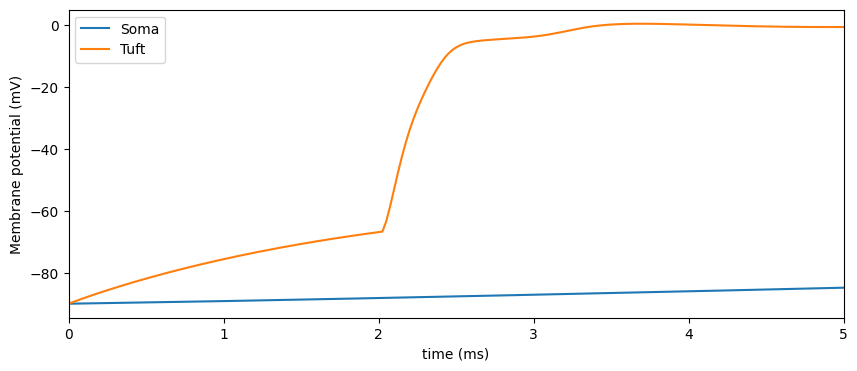

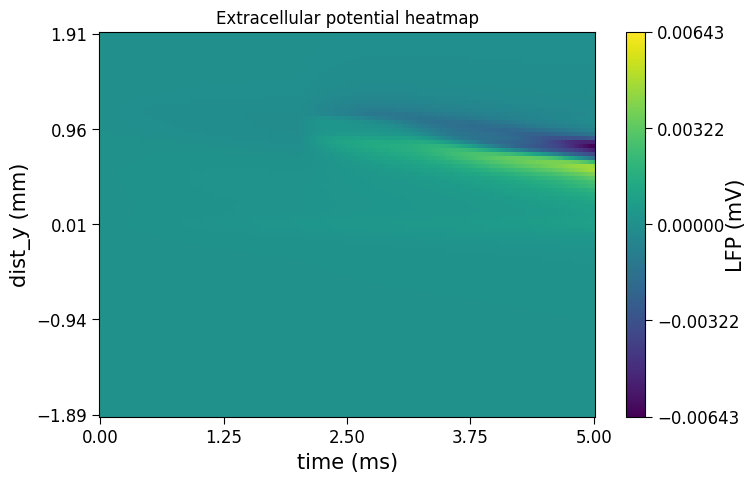

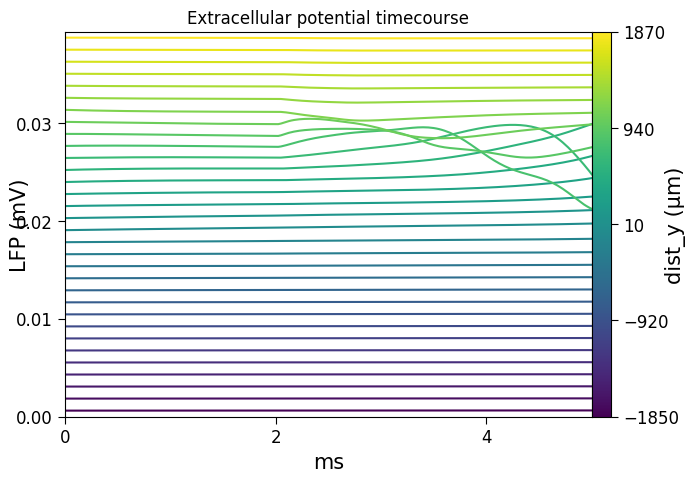

In [40]:
#settings
vlimset='max'#[-.02,.02]#[-.01,.01]#'auto'#[-.00722,.00722]#'auto' #heatmap range (mV)
ylimset=[-2500,2500] #[-1200,1200]#y dist range for plotting (microns)

# Run simulation
if original_syns:
  set_synapse()
# else: # View synapses
#   for syn in cell.synapse:
#     if syn.gmax_var == '_nc_weight':
#       print(syn.syn, [nc.weight[0] for nc in syn.ncs])
#     else:
#       print('synapse',syn.syn,':',syn.get_segment(),'weight:',syn.syn.initW, 'ncs:',syn.ncs)

h.run()
# Get results
t = t_vec.as_numpy().copy()  # time array (ms)
# soma membrane potential
Vm = V_rec.as_numpy()

soma_seg_index=cell.segments.index(cell.soma(0.5))
axon_seg_index=cell.segments.index(cell.axon[-1](0.9))
#choose a tuft to plot voltage
if (reduce_cell == True) and ( expand_cable==False):
  tuft_seg_index=cell.segments.index(tufts[0](0.9))# tufts[0] will be the cable that is both trunk and tuft in this case, so we have to specify near end of cable
else:
  tuft_seg_index=cell.segments.index(tufts[0](0.5))# otherwise tufts[0] will be truly tuft section and the segment in the middle of section is fine
print("Plotting",cell.segments[soma_seg_index],"Voltage| y coordinate of this seg:", cell.seg_coords['pc'][soma_seg_index][1])
print("Plotting",cell.segments[tuft_seg_index],"Voltage| y coordinate of this seg:", cell.seg_coords['pc'][tuft_seg_index][1])

v_soma = Vm[soma_seg_index]
v_tfut = Vm[tuft_seg_index]
v_axon = Vm[axon_seg_index]

# lfp array
lfp = ecp.calc_ecp(move_cell=loc_param).T  # unit: mV

# Soma membrane potential
plt.figure(figsize=(10, 4))
plt.plot(t, v_soma, label='Soma')
plt.plot(t, v_tfut, label='Tuft')
# plt.plot(t, v_axon, label='axon')
plt.ylabel('Membrane potential (mV)')
plt.xlabel('time (ms)')
plt.xlim(t[[0, -1]])
plt.legend()
plt.savefig('Vm')

# Extracellular potential along y-axis
y_window = ylimset  # select range of y coordinate for plotting
ylim = loc_param[1] + np.array(y_window)  # set range of y coordinate
max_idx = np.argmax(np.amax(np.abs(lfp), axis=0))  # find the electrode that records maximum magnitude
x_dist = elec_pos[max_idx, 0]  # x coordinate of the maximum magnitude electrode
e_idx = (elec_pos[:, 0]==x_dist) & (elec_pos[:, 1]>=ylim[0]) & (elec_pos[:, 1]<=ylim[1])  # selected electrode indices

fontsize = 15
labelpad = -10
ticksize = 12
tick_length = 5
nbins = 5
plt.figure(figsize=(8, 5))
_ = plot_lfp_heatmap(t=t, elec_d=elec_pos[e_idx, 1], lfp=lfp[:, e_idx],
                     fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                     nbins=nbins, vlim=vlimset, axes=plt.gca()) #vlim='auto';normal range seems to be ~ [-.00722,.00722]
#plt.hlines(0,xmin=min(t),xmax=max(t),linestyles='dashed') # create a horizontal line
plt.title('Extracellular potential heatmap')
plt.savefig('ECP heatmap')
plt.figure(figsize=(8, 5))
_ = plot_lfp_traces(t, lfp[:, e_idx][:,1::3], electrodes=elec_pos[e_idx][1::3],
                    fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                    nbins=nbins, axes=plt.gca())
plt.title('Extracellular potential timecourse')
plt.savefig('ECP timecourse')

plt.show()

## Electrotonic distance -- needs update

Neuron has a tool for electrotonic analysis [https://www.neuron.yale.edu/neuron/static/docs/zclass/zclass.html](https://www.neuron.yale.edu/neuron/static/docs/zclass/zclass.html). It computes the electrotonic distance defined by attenuation, but the classical definition is [anatomical distance/length constant](https://www.neuron.yale.edu/neuron/static/docs/zclass/NIPS94/nipsfin.html).

The plot below shows the membrane potential timecourse at several locations on the cell. The electrotonic distance computed by Neuron of each location is also shown with both number and color. The distance should always be a positive value, but it is labeled negative for the basal dendrites and the axon intentionally so that it can be easily distinguished from the apical dendrites.

In [ ]:
# geometry=cell.geometry

In [ ]:
# for syn in cell.synapse:
#     syn.set_gmax(0)
# h.run()

# sec_type_swc = {sec['name']: sec['type'] for _, sec in geometry.iterrows()}
# # sec_type = [sec_type_swc[sec.name().split('.')[-1]] for sec in cell.all] # original
# # sec_type = [sec_type_swc[sec.name().split('.')[-1].split('[')[0]] for sec in cell.all] # possible alternative?
# sec_type = [sec_type_swc[sec.name()] for sec in cell.all]
# freq = 0 # Hz
# seg_prop, _, _ = measure_segment_distance(cell.soma , cell.all, sec_type, freq)

# select_seg = [[cell.sec_id_in_seg[sec[0]], cell.get_sec_by_id(sec[0]).nseg -1] for sec in cell.sec_id_lookup.values()]
# select_seg = np.sum(np.array(select_seg), axis=1)
# # select_seg = np.unique(np.cumsum(np.array(select_seg), axis=1).ravel())
# _ = plot_variable_with_morphology(cell.seg_coords, seg_prop, Vm, t=t, axes=['x', 'y'],
#                                   distance_type='elec_dist', n_dist=300,
#                                   select_seg=select_seg, max_per_dist=1, varname='Membrane potential (mV)',
#                                   space=2., normalized_space=True, sort_by_dist=True,
                                  # figsize=(10, 10), fontsize=15, scalebar_size=50)

##Transfer Impedance



In [ ]:
# import numpy as np
# from neuron import h
# import cmath

# def measure_segment_transfer_impedance(soma, section_list, sec_type, freq=0, extracellular_mechanism=True):
#     """
#     soma: soma section object
#     section_list: list of sections
#     sec_type: list of swc type id of sections
#     freq: frequency (Hz) at which electrotonic distance is evaluated
#     extracellular_mechanism: whether extracellular mechanism is used
#     """
#     seg_prop = {}
#     swc_type = []
#     seg_area = []
#     seg_dist = []
#     seg_length = []
#     elec_dist = [] #modulus part of polar form #should change names
#     elec_dist0 = [] #modulus of polar form #should change names
#     transfer_imps = [] #real part of rectangular form
#     transfer_imps0 = [] # real part of rectangular form

#     # set up distance origin
#     h.distance(0, soma(.5))
#     # set up electrotonic origin
#     zz = h.Impedance()
#     zz.loc(soma(.5))
#     if extracellular_mechanism:
#         zz.compute(freq + 1 / 9e9, 0) #*
#     else:
#         zz.compute(freq, 1)
#     # measure distance
#     for i, sec in enumerate(section_list):
#         if sec_type[i]==1:
#             transfer_imp=zz.transfer(sec(0.5/sec.nseg)) #*
#             transfer_phase=zz.transfer_phase(sec(0.5/sec.nseg)) #*
#             elec_dist0.append(transfer_imp) #*
#             rect_complex=cmath.rect(transfer_imp,transfer_phase)
#             transfer_imps.append(rect_complex.real) #*
#         else:
#             transfer_imp=zz.transfer(sec.parentseg()) #*
#             transfer_phase=zz.transfer_phase(sec.parentseg()) #*
#             elec_dist0.append(transfer_imp) #*
#             rect_complex=cmath.rect(transfer_imp, transfer_phase) #*
#             transfer_imps.append(rect_complex.real) #*
#         for j, seg in enumerate(sec):
#             swc_type.append(sec_type[i])
#             seg_area.append(seg.area())
#             seg_dist.append(h.distance(seg))
#             seg_length.append(sec.L/sec.nseg)
#             if j!=0:
#                 elec_dist0.append(elec_dist[-1])
#                 transfer_imps.append(transfer_imps0[-1])
#             elec_dist.append(zz.transfer(seg)) #*
#             transfer_imp=zz.transfer(seg) #*
#             transfer_phase=zz.transfer_phase(seg) #*
#             rect_complex=cmath.rect(transfer_imp,transfer_phase) #*
#             transfer_imps0.append(rect_complex.real) #*

#     seg_prop['swc_type'] = np.array(swc_type)
#     seg_prop['seg_area'] = np.array(seg_area)

#     # distance at endpoints of each segment
#     seg_prop['distance'] = np.expand_dims(seg_dist, 1) + np.expand_dims(seg_length, 1) / 2 * np.array([[-1, 1]])
#     # seg_prop['transfer_imp'] = np.sort(np.log(elec_dist0[0]) - np.log(np.column_stack([elec_dist0, elec_dist])), axis=1) #*
#     seg_prop['transfer_imp_mod'] = np.sort(elec_dist0[0] - np.column_stack([elec_dist0, elec_dist]), axis=1) #*
#     seg_prop['transfer_imp_real'] = np.sort(transfer_imps[0] - np.column_stack([transfer_imps, transfer_imps0]), axis=1) #*


#     # change sign of basal and axon types
#     idx = np.nonzero((seg_prop['swc_type']==2) | (seg_prop['swc_type']==3))[0]
#     seg_prop['distance'][idx] = -seg_prop['distance'][idx,::-1]
#     seg_prop['transfer_imp_mod'][idx] = -seg_prop['transfer_imp_mod'][idx,::-1] #*
#     seg_prop['transfer_imp_real'][idx] = -seg_prop['transfer_imp_real'][idx,::-1] #*
#     return seg_prop, zz.transfer(soma(.5)), zz.transfer_phase(soma(.5))


In [ ]:
# #using modulus of polar form

# for syn in cell.synapse:
#     syn.set_gmax(0)
# h.run()

# sec_type_swc = {sec['name']: sec['type'] for _, sec in geometry.iterrows()}
# sec_type = [sec_type_swc[sec.name().split('.')[-1]] for sec in cell.all]
# freq = 0 # Hz
# seg_prop, _, _ = measure_segment_transfer_impedance(cell.soma , cell.all, sec_type, freq)

# select_seg = [[cell.sec_id_in_seg[sec[0]], cell.get_sec_by_id(sec[0]).nseg -1] for sec in cell.sec_id_lookup.values()]
# select_seg = np.sum(np.array(select_seg), axis=1)
# # select_seg = np.unique(np.cumsum(np.array(select_seg), axis=1).ravel())
# _ = plot_variable_with_morphology(cell.seg_coords, seg_prop, Vm, t=t, axes=['x', 'y'],
#                                   distance_type='transfer_imp_mod', n_dist=300,
#                                   select_seg=select_seg, max_per_dist=1, varname='Membrane potential (mV)',
#                                   space=2., normalized_space=True, sort_by_dist=True,
#                                   figsize=(10, 10), fontsize=15, scalebar_size=50)

In [ ]:
# #using real part of rectangular complex form

# for syn in cell.synapse:
#     syn.set_gmax(0)
# h.run()

# sec_type_swc = {sec['name']: sec['type'] for _, sec in geometry.iterrows()}
# sec_type = [sec_type_swc[sec.name().split('.')[-1]] for sec in cell.all]
# freq = 0 # Hz
# seg_prop, _, _ = measure_segment_transfer_impedance(cell.soma , cell.all, sec_type, freq)

# select_seg = [[cell.sec_id_in_seg[sec[0]], cell.get_sec_by_id(sec[0]).nseg -1] for sec in cell.sec_id_lookup.values()]
# select_seg = np.sum(np.array(select_seg), axis=1)
# # select_seg = np.unique(np.cumsum(np.array(select_seg), axis=1).ravel())
# _ = plot_variable_with_morphology(cell.seg_coords, seg_prop, Vm, t=t, axes=['x', 'y'],
#                                   distance_type='transfer_imp_real', n_dist=300,
#                                   select_seg=select_seg, max_per_dist=1, varname='Membrane potential (mV)',
#                                   space=2., normalized_space=True, sort_by_dist=True,
#                                   figsize=(10, 10), fontsize=15, scalebar_size=50)

Transfer Impedance is a complex number

In [ ]:
# polar_modulus=1
# polar_phase=3

# complex_rectangular_form=cmath.rect(polar_modulus, polar_phase)
# print(complex_rectangular_form)

In [ ]:
# complex_rectangular_form.real